In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from utility import *
import datetime
from copy import deepcopy

from utility_HJo import *  # defines concatDF, dataPrep function, etc
from utility_HJo_condRNN import *  # defines functions related to condRNN

In [2]:
homedir = get_homedir(verbose=True)

C:\Users\HyeongChan Jo\OneDrive - California Institute of Technology\class\COVID-19\SKTW


In [3]:
FIPS_mapping, _ = get_FIPS()

## Demographic data

In [113]:
# retrieve berkeley dataset for demogaphical data
df_berk_orig = pd.read_csv("../data/us/aggregate_berkeley.csv")
df_berk_orig["countyFIPS"]=df_berk_orig["countyFIPS"].apply(correct_FIPS)
df_berk = fix_FIPS(df_berk_orig, fipslabel="countyFIPS")
df_berk.set_index(['countyFIPS'], inplace = True)
df_berk_orig.set_index(['countyFIPS'], inplace = True)

In [114]:
df_berk_orig.columns = df_berk_orig.columns.str.replace("'"," ")
df_berk.columns = df_berk.columns.str.replace("'"," ")

## Geolocation data

In [115]:
# retrieve geolocation data
df_geo = pd.read_csv("../data/us/geolocation/county_centers.csv")
df_geo["fips"]=df_geo["fips"].apply(correct_FIPS)
df_geo = fix_FIPS(df_geo, fipslabel="fips", reduced=True)
df_geo.set_index(['fips'], inplace = True)

In [116]:
# add population-weighted center location of each county to df_berk
df_geo_temp = df_geo[["pclon10", "pclat10"]]
df_berk2 = pd.concat([df_berk, df_geo_temp.reindex(df_berk.index)], axis = 1, sort=False, join='outer')

## GDP data

In [117]:
df_GDP = pd.read_csv("../JK/GDP.csv")
df_GDP["fips"]=df_GDP["fips"].apply(correct_FIPS)
df_GDP = fix_FIPS(df_GDP, fipslabel="fips", reduced=True)
df_GDP.set_index(['fips'], inplace = True)
# change column names
df_GDP.rename(columns={"2015": "GDP_2015", "2016": "GDP_2016", "2017": "GDP_2017", "2018": "GDP_2018"},  inplace = True)
#df_GDP.head()

df_berk2 = pd.concat([df_berk2, df_GDP.reindex(df_berk.index)], axis = 1, sort=False, join='outer')
df_berk2.columns

Index(['Unnamed: 0', 'PopulationEstimate2018', 'Population(Persons)2017',
       'PopTotalMale2017', 'PopTotalFemale2017', 'FracMale2017',
       'PopulationEstimate65+2017', 'PopulationDensityperSqMile2010',
       'CensusPopulation2010', 'MedianAge2010', 'MedianAge,Male2010',
       'MedianAge,Female2010', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', '#FTEHospitalTotal2017',
       'TotalM.D. s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
       'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
       'PopMale35-442010', 'PopFmle35-442

## Cluster data from Juhyun's work

In [118]:
path = r"\exploratory_HJo\n_clusters=5_kmeans_extended.txt"
with open(f'{homedir}'+path, 'r') as f:
    dic_cluster = eval(f.read())

## Mortality data

In [354]:
# retrieve nyt mortality data for the values to be predicted
# df_nyt = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv", index_col=[0,1])
df_nyt_orig = pd.read_csv("../data/us/covid/nyt_us_counties.csv") # , index_col=[0,3]      0: date, 3: fips
df_nyt_orig.dropna(subset = ["fips"], inplace = True)
df_nyt_orig['weekday'] = df_nyt_orig['date']
df_nyt_orig['weekday'] = pd.to_datetime(df_nyt_orig['weekday'], format = "%Y-%m-%d")
df_nyt_orig['weekday'] = df_nyt_orig['weekday'].dt.dayofweek
df_nyt_orig["fips"]=df_nyt_orig["fips"].apply(correct_FIPS)
df_nyt = fix_FIPS(df_nyt_orig, fipslabel="fips", datelabel = "date", reduced=True)

df_nyt.set_index(['date', 'fips'], inplace = True)

dateList = df_nyt.index.levels[0]
fipsList = df_nyt.index.levels[1]
print(fipsList)

# define separate df for each of the counties
df_nyt_eachCounty_accum = [df_nyt.xs(fips, level = 'fips') for fips in fipsList]
df_nyt_eachCounty = deepcopy(df_nyt_eachCounty_accum)
for i in range(len(df_nyt_eachCounty)):
    df_nyt_eachCounty[i].deaths = np.diff(np.concatenate(([0], df_nyt_eachCounty[i].loc[:, 'deaths'])) )


Index(['01001', '01003', '01005', '01007', '01009', '01011', '01013', '01015',
       '01017', '01019',
       ...
       '56025', '56027', '56029', '56031', '56033', '56035', '56037', '56039',
       '56041', '56043'],
      dtype='object', name='fips', length=2927)


In [356]:
df_nyt_eachCounty[1]

,cases,deaths,weekday
date,,,
2020-03-14,1,0,5
2020-03-15,1,0,6
2020-03-16,1,0,0
2020-03-17,1,0,1
2020-03-18,1,0,2
...,...,...,...
2020-05-17,254,0,6
2020-05-18,260,0,0
2020-05-19,262,0,1


In [357]:
# dataframe for converting fips into state
df_fips2state = df_nyt_orig[['state', 'fips']].copy()
df_fips2state.drop_duplicates(inplace = True)
df_fips2state.set_index('fips', inplace = True)
#print(df_fips2state.loc['02050', 'state'])

## Mobility data

In [121]:
# get neighboring county data so that we can fill the missing data in mobility dataset
df_neighbor = pd.read_csv("../data/us/geolocation/neighborcounties.csv")
df_neighbor["orgfips"]=df_neighbor["orgfips"].apply(correct_FIPS)
df_neighbor["adjfips"]=df_neighbor["adjfips"].apply(correct_FIPS)
df_neighbor.set_index(['orgfips'], inplace = True)
df_neighbor.head()

,adjfips,instate
orgfips,,
01001,01021,1
01001,01047,1
01001,01051,1
01001,01085,1
01001,01101,1


In [122]:
#df_mobility.xs("1", level = 'fips')
#df_mobility.head()
#df_berk2.loc["fips", 'State']
df_mobility_orig = pd.read_csv('../data/us/mobility/DL-us-mobility-daterow.csv')
df_mobility_orig = df_mobility_orig[~np.isnan(df_mobility_orig.fips)]
df_mobility_orig["fips"]=df_mobility_orig["fips"].apply(correct_FIPS)
df_mobility = fix_FIPS(df_mobility_orig, fipslabel="fips", datelabel = "date", reduced=True)
df_mobility.set_index(['date', 'fips'], inplace=True)

#print(df_mobility_orig.loc[1, 'admin_level'])
#print(df_mobility_orig[0:10])

In [123]:
# retrieve mobility data. The data has been collected from from March 1st
df_mobility = pd.read_csv('../data/us/mobility/DL-us-mobility-daterow.csv')
df_mobility = df_mobility[~np.isnan(df_mobility.fips)]
df_mobility["fips"]=df_mobility["fips"].apply(correct_FIPS)
df_mobility = fix_FIPS(df_mobility, fipslabel="fips", datelabel = "date", reduced=True)
df_mobility.set_index(['date', 'fips'], inplace=True)

df_mobility_eachCounty = []
for fips in fipsList:
    try: 
        df_mobility_eachCounty.append( df_mobility.xs(fips, level = 'fips') )
    except  KeyError:
        print('fips ', fips, 'not found - using state-wise mobility data')
        state = df_fips2state.loc[fips, 'state']
        if fips == '11001':
            state = 'Washington, D.C.' # originally it's District of columnbia, which is not on mobility data
            
        df_mobility_eachCounty.append( df_mobility_orig[ (df_mobility_orig['admin_level']==1) & (df_mobility_orig['admin1']==state)] )
        df_mobility_eachCounty[-1].set_index('date', inplace=True)
        if len(df_mobility_eachCounty[-1])==0:
            print('     caution: no data for ', fips)
   


fips  02050 not found - using state-wise mobility data
fips  02150 not found - using state-wise mobility data
fips  02180 not found - using state-wise mobility data
fips  02188 not found - using state-wise mobility data
fips  02195 not found - using state-wise mobility data
fips  02201 not found - using state-wise mobility data
fips  02220 not found - using state-wise mobility data
fips  02240 not found - using state-wise mobility data
fips  02261 not found - using state-wise mobility data
fips  02290 not found - using state-wise mobility data
fips  05049 not found - using state-wise mobility data
fips  05101 not found - using state-wise mobility data
fips  06003 not found - using state-wise mobility data
fips  06105 not found - using state-wise mobility data
fips  08009 not found - using state-wise mobility data
fips  08011 not found - using state-wise mobility data
fips  08017 not found - using state-wise mobility data
fips  08021 not found - using state-wise mobility data
fips  0802

fips  31167 not found - using state-wise mobility data
fips  31171 not found - using state-wise mobility data
fips  31175 not found - using state-wise mobility data
fips  31181 not found - using state-wise mobility data
fips  32015 not found - using state-wise mobility data
fips  32017 not found - using state-wise mobility data
fips  32021 not found - using state-wise mobility data
fips  35003 not found - using state-wise mobility data
fips  35021 not found - using state-wise mobility data
fips  35059 not found - using state-wise mobility data
fips  36041 not found - using state-wise mobility data
fips  37075 not found - using state-wise mobility data
fips  37095 not found - using state-wise mobility data
fips  37177 not found - using state-wise mobility data
fips  38005 not found - using state-wise mobility data
fips  38009 not found - using state-wise mobility data
fips  38011 not found - using state-wise mobility data
fips  38013 not found - using state-wise mobility data
fips  3802

## Seasonality data

In [124]:
df_seasonality = pd.read_csv('../exploratory_HJo/seasonality_stateLevel.csv', index_col='state')
#print(df_seasonality)

## COVID Test Result data

In [125]:
df_testResult = pd.read_csv('../data/us/covid/daily_state_tests.csv')
df_testResult.set_index(['date', 'fips'], inplace=True)

df_state2fips = df_mobility_orig[ (df_mobility_orig['admin_level']==1)].copy()
df_state2fips = df_state2fips.loc[:, ['admin1', 'fips']]
df_state2fips.drop_duplicates(inplace = True)
df_state2fips.set_index('admin1', inplace = True)

df_testResult_eachCounty = []
for fips in fipsList:
    state = df_fips2state.loc[fips, 'state']
    if fips == '11001':
        state = 'Washington, D.C.' # originally it's District of columnbia, which is not on mobility data
    state_fips = int(df_state2fips.loc[state, 'fips'])

    df_testResult_eachCounty.append( df_testResult.xs(state_fips, level = 'fips') )
    #df_testResult_eachCounty[-1].sort_index(axis = 0, ascending=True, inplace=True) 
    df_testResult_eachCounty[-1] = df_testResult_eachCounty[-1].sort_index(axis = 0, ascending=True) 
    df_testResult_eachCounty[-1] = df_testResult_eachCounty[-1].fillna(0)

In [126]:
df_testResult_eachCounty[90]
print(df_testResult_eachCounty[0].columns)

Index(['state', 'positive', 'negative', 'pending', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'hash', 'dateChecked', 'death',
       'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease'],
      dtype='object')


## Concatenate dataframes - static values

In [18]:
def concatDF_static(data1, column1, fipsList, df_death_accum, minDeathNumber = 0, dic_cluster = []):
    # inputs
    #   data:               list of input dataframes
    #   columnName:         list of lists storing column names of input dataframes to be used
    #   fipsList:           list of fips of the counties to be used
    #   minDeathNumber:     minimum number of accumulative death on the last day that the dataset should satisfy - counties with less number of death will be removed
    
    # divide the fipslist based on the minDeathNumber
    totalNumDeath = [df_death_accum[x].iloc[-1, -1] for x in range(len(df_death_accum))]
    fipsList = [fipsList[i] for i in range(len(fipsList)) if totalNumDeath[i]>=minDeathNumber]
    
    # save the original data
    data1_orig = data1.copy()
    
    # go over each FIPS value
    dataList = []
    fips_noData = []
    fips_final = []
    for i, fips in enumerate(fipsList):
        # for data1 (demographic)
        try: 
            data1 = data1_orig.loc[fips, column1].to_numpy()
            if len(dic_cluster)!=0:
                data1 = np.append(data1, dic_cluster[fips])
        except  KeyError:
            print('fips ', fips, 'not found')
            fips_noData.append(fips)
            continue
        fips_final.append(fips)
        
        dataList.append(data1)
        
    return dataList, fips_noData, fips_final


# columns_demo = ['PopulationDensityperSqMile2010', 'PopTotalMale2017', 'PopTotalFemale2017',
#                 'MedianAge2010', 'MedianAge,Male2010', 'MedianAge,Female2010',
#                 '#Hospitals', '#ICU_beds', 'DiabetesPercentage', 'HeartDiseaseMortality',
#                 'StrokeMortality', 'Smokers_Percentage', 'MedicareEnrollment,AgedTot2017']

columns_demo = ['PopulationEstimate2018', 'Population(Persons)2017',
       'PopTotalMale2017', 'PopTotalFemale2017', 'FracMale2017',
       'PopulationEstimate65+2017', 'PopulationDensityperSqMile2010',
       'CensusPopulation2010', 'MedianAge2010', 'MedianAge,Male2010',
       'MedianAge,Female2010', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', '#FTEHospitalTotal2017','#HospParticipatinginNetwork2017',
       'TotalM.D. s,TotNon-FedandFed2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
       'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
       'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
       'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
       'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
       'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010',
       'PopMale>842010', 'PopFmle>842010', '3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge5-14Years2015-17',
       '3-YrMortalityAge15-24Years2015-17',
       '3-YrMortalityAge25-34Years2015-17',
       '3-YrMortalityAge35-44Years2015-17',
       '3-YrMortalityAge45-54Years2015-17',
       '3-YrMortalityAge55-64Years2015-17',
       '3-YrMortalityAge65-74Years2015-17',
       '3-YrMortalityAge75-84Years2015-17', '3-YrMortalityAge85+Years2015-17',
       'mortality2015-17Estimated', 'pclon10', 'pclat10', 'GDP_2015', 'GDP_2016', 'GDP_2017', 'GDP_2018']

dataList_static, fips_noData_static, fips_final_static = concatDF_static(df_berk2, columns_demo, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])

fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not found
fips  02261 not found
fips  02290 not found
fips  08014 not found
fips  46102 not found


## Concatenate dataframes - timeseries data

In [154]:
import calendar
from scipy import interpolate

def concatDF_timeseries(data2, data3, data4, data5, column2, column3, column4, column5, fipsList, df_fips2state, data_demo, fipsList_demo, date_st, date_ed, 
             df_death_accum, minDeathNumber = 0, smoothData = False, exp = 2, removeNeg = True, normalizeTarget = False):
    # inputs
    #   data:               list of input dataframes
    #   columnName:         list of lists storing column names of input dataframes to be used
    #   fipsList:           list of fips of the counties to be used
    #   fipsList_demo:      list of fips of the counties that were found in demogrpahic dataset
    #   date_st:            starting date of the dataset to be used, in datetime variable
    #   date_ed:            ending date of the dataset to be used, in datetime variable
    #   minDeathNumber:     minimum number of accumulative death on the last day that the dataset should satisfy - counties with less number of death will be removed
    #   smoothData:         whether to smooth the data with exponential filter
    #   exp:                base of the exponential filter
    #   removeNeg:          if it's true, change negative values into zeros when deaths<0
    #   normalizeTarget:    if it's true, normalize the target (deaths) too
    
    # divide the fipslist based on the minDeathNumber
    totalNumDeath = [df_death_accum[x].iloc[-1, -1] for x in range(len(df_death_accum))]
    fipsList = [fipsList[i] for i in range(len(fipsList)) if totalNumDeath[i]>=minDeathNumber]
    data2 = [data2[i] for i in range(len(fipsList)) if fipsList[i] in fipsList]

    # handle dates
    date_st_str = date_st.strftime("%Y-%m-%d")
    date_ed_str = date_ed.strftime("%Y-%m-%d")
    date_st_str_test = date_st.strftime("%Y%m%d")  # for test result dataframe
    date_ed_str_test = date_ed.strftime("%Y%m%d")  # for test result dataframe
    numDays = (date_ed-date_st).days+1
    date_st_seasonality = date_st - relativedelta(years=3)  # seasonality data has been saved based on 2017 data
    date_st_seasonality = date_st_seasonality.strftime("%Y-%m-%d")
    date_ed_seasonality = date_ed - relativedelta(years=3)
    date_ed_seasonality = date_ed_seasonality.strftime("%Y-%m-%d")
    
    # save the original data
    data2_orig = data2.copy()
    data3_orig = data3.copy()
    data4_orig = data4.copy()
    data5_orig = data5.copy()
    
    # go over each FIPS value
    dataList = []
    fips_noData = []
    fips_final = []
    for i, fips in enumerate(fipsList):
        if fips not in fipsList_demo:
            continue
        
        # for data2 (mortality)
        data2 = data2_orig[i].loc[date_st_str:date_ed_str, column2].to_numpy()
        if data2.shape[0]<numDays:
            data2 = np.concatenate( (np.zeros((numDays-data2.shape[0], len(column2))), data2), axis = 0)        
        if removeNeg: 
            data2[data2[:,1]<0, 1] = 0
        if smoothData:
            for i in range(data2.shape[0]):
                if i == 0: continue
                data2[i, 1] = data2[i, 1]+data2[i-1, 1]/exp
        
        # for data3 (mobility)
        data3 = data3_orig[i].loc[date_st_str:date_ed_str, column3].to_numpy()
        # If there are days without mobility data, copy and paste the first & last mobility data for the dates before & after the existing data
        # For the rest of the data set, use spline interpolation
        if len(data3)<numDays and len(column3)!=0:
            data3_temp = data3_orig[i].loc[date_st_str:date_ed_str, column3]
            
            # get dates on dataframe
            date = [datetime.datetime.strptime(x, "%Y-%m-%d") for x in data3_temp.index]  # given dates shown on df
            
            # figure out the first and last date on the dataset
            date_ed_temp = date[-1]  # last date in the data
            date_st_temp = date[0]   # first date in the data
            numDays_temp = (date_ed_temp - date_st_temp).days+1
            numDays_bef = (date_st_temp - datetime.datetime.combine(date_st, datetime.time(0, 0))).days  # number of dates with missing data in the beginning
            numDays_aft = (datetime.datetime.combine(date_ed, datetime.time(0, 0)) - date_ed_temp).days  # number of dates with missing data at the end
            
            # convert dates into timestamps. timestamp is for converting dates into numpy array for spline interpolation
            date_timestamp = np.array([calendar.timegm(x.timetuple()) for x in date])
            date_mid = [date_st_temp + datetime.timedelta(days=x) for x in range(numDays_temp)]  # full list of dates from the first to the last date on a dataset
            date_mid_timestamp = np.array([calendar.timegm(x.timetuple()) for x in date_mid])
            
            data3_mid = []
            for x, column3_each in enumerate(column3):  # go over each column specified in column3
                spl = interpolate.splrep(date_timestamp, data3[:, x], s=0)
                data3_mid.append( interpolate.splev(date_mid_timestamp, spl, der=0) )
            data3 = np.transpose(np.array(data3_mid).copy())
            
            # fill the beginning and the end of the data by copying & pasting the first & last data
            if numDays_bef!=0:
                data3_bef = np.kron( np.ones((numDays_bef,1)), data3[0, :])
                data3 = np.vstack( (data3_bef, data3) )
            if numDays_aft!=0:
                data3_aft = np.kron( np.ones((numDays_aft,1)), data3[-1, :])
                data3 = np.vstack( (data3, data3_aft) )
                    
        # for data4 (seasonality)
        state = df_fips2state.loc[fips, 'state']
        data4 = data4_orig.loc[state, :]
        data4.set_index('date', inplace=True)
        data4 = data4.loc[date_st_seasonality:date_ed_seasonality, column4]
        
        # for data5 (test result data)
        if len(column5)!=0:
            data5 = data5_orig[i].loc[date_st_str_test:date_ed_str_test, column5].to_numpy()
            # If there are days without test result data, copy and paste the first & last data for the dates before & after the existing data
            # For the rest of the data set, use spline interpolation
            if len(data5)<numDays:
                data5_temp = data5_orig[i].loc[date_st_str_test:date_ed_str_test, column5]

                # get dates on dataframe
                date = [datetime.datetime.strptime(str(x), "%Y%m%d") for x in data5_temp.index]  # given dates shown on df

                # figure out the first and last date on the dataset
                date_ed_temp = date[-1]  # last date in the data
                date_st_temp = date[0]   # first date in the data
                numDays_temp = (date_ed_temp - date_st_temp).days+1
                numDays_bef = (date_st_temp - datetime.datetime.combine(date_st, datetime.time(0, 0))).days  # number of dates with missing data in the beginning
                numDays_aft = (datetime.datetime.combine(date_ed, datetime.time(0, 0)) - date_ed_temp).days  # number of dates with missing data at the end

                # convert dates into timestamps. timestamp is for converting dates into numpy array for spline interpolation
                date_timestamp = np.array([calendar.timegm(x.timetuple()) for x in date])
                date_mid = [date_st_temp + datetime.timedelta(days=x) for x in range(numDays_temp)]  # full list of dates from the first to the last date on a dataset
                date_mid_timestamp = np.array([calendar.timegm(x.timetuple()) for x in date_mid])

                data5_mid = []
                for x, column5_each in enumerate(column5):  # go over each column specified in column3
                    spl = interpolate.splrep(date_timestamp, data5[:, x], s=0)
                    data5_mid.append( interpolate.splev(date_mid_timestamp, spl, der=0) )
                data5 = np.transpose(np.array(data5_mid).copy())

                # fill the beginning and the end of the data by copying & pasting the first & last data
                if numDays_bef!=0:
                    data5_bef = np.kron( np.ones((numDays_bef,1)), data5[0, :])
                    data5 = np.vstack( (data5_bef, data5) )
                if numDays_aft!=0:
                    data5_aft = np.kron( np.ones((numDays_aft,1)), data5[-1, :])
                    data5 = np.vstack( (data5, data5_aft) )
                
        if len(column3)!=0:
            data = np.hstack( (data2, data3) )    
        else:
            data = data2
            
        if len(column4)!=0:
            data = np.hstack( (data, data4) )    
        
        if len(column5)!=0:
            data = np.hstack( (data, data5) )    
        
        dataList.append(data)
        
    return dataList, fips_noData, fips_final





date_st = datetime.date(2020, 3, 1)
date_ed = datetime.date(2020, 5, 21)
normalizeTarget = False

columns_mortality = ['cases', 'deaths', 'weekday']
columns_mobility = ['m50', 'm50_index']
columns_season = ['seasonality']
# columns_testResult = ['positive', 'negative', 'hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently']
columns_testResult = ['positive', 'negative', 'pending', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 
       'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease'] # removed dataQualityGrade, lastUpdateEt, hash, dateChecked, as they are not numerical
    # also removed death as it's redundant
#columns_testResult = []

# without test result data
# dataList_time, fips_noData_time, fips_final_time = concatDF_timeseries(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, 
#                                                          columns_mortality, columns_mobility, columns_season, 
#                                                          fipsList, df_fips2state, df_berk2, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 0)

# with test result data
dataList_time, fips_noData_time, fips_final_time = concatDF_timeseries(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, df_testResult_eachCounty,
                                                         columns_mortality, columns_mobility, columns_season, columns_testResult,
                                                         fipsList, df_fips2state, df_berk2, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 0)




# dataList_deathOver0, fips_noData_deathOver0, fips_final_deathOver0 = concatDF(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, 
#                                                          columns_mortality, columns_mobility, columns_season, 
#                                                          fipsList, df_berk, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 1)

# dataList_deathOver10, fips_noData_deathOver10, fips_final_deathOver10 = concatDF(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, 
#                                                          columns_mortality, columns_mobility, columns_season, 
#                                                          fipsList, df_berk, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 11)

In [79]:
# normalization
data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static)
data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)
# data_DeathOver0_zscore, data_DeathOver0_mean, data_DeathOver0_std = normalizeData(dataList_deathOver0)
# data_DeathOver10_zscore, data_DeathOver10_mean, data_DeathOver10_std = normalizeData(dataList_deathOver10)

## Define training data&ans and testing data&ans


In [80]:
# for static dataset
inputSize = 7
trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)
print(trainingData_static.shape)

(136770, 70)


In [81]:
# for timeseries dataset
columns_time = columns_mortality + columns_mobility + columns_season + columns_testResult
trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time)
print(trainingData_time.shape)

(136770, 7, 24)


In [82]:
# unnormalize the targets
normalizeTarget = False

if not normalizeTarget:
    trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time, 'deaths')

In [83]:
print(np.argmax(trainingData_time))
np.unravel_index(np.argmax(trainingData_time), trainingData_time.shape)
#np.isnan(np.sum(testingData_time))
print(trainingData_time.mean(axis = 0))

8616867
[[-9.57908556e-02 -5.51869497e-02  1.52537143e-02  9.77970753e-03
   6.62738502e-01 -2.74032712e-01 -4.35900122e-01  4.01896276e-02
  -1.81917459e-01 -1.39298320e-01 -1.34643435e-01 -2.56678343e-01
  -1.75513715e-01 -1.20838329e-01 -2.82875985e-01 -1.39298320e-01
  -4.23494220e-01 -4.24051046e-01 -4.24051046e-01 -1.41287744e-01
  -3.62730101e-02 -3.28674108e-01 -1.48348242e-01 -3.25931340e-01]
 [-9.25986245e-02 -5.13182245e-02  1.36615979e-02  9.48194787e-03
   6.29570544e-01 -2.64686078e-01 -4.25571769e-01  4.15517092e-02
  -1.67573303e-01 -1.34027436e-01 -1.21520989e-01 -2.51501054e-01
  -1.62544712e-01 -1.18289545e-01 -2.78569639e-01 -1.34027436e-01
  -4.12851930e-01 -4.13455099e-01 -4.13455099e-01 -1.27411216e-01
  -2.84652635e-02 -3.18622708e-01 -1.31533593e-01 -3.14457715e-01]
 [-8.92713964e-02 -4.79982272e-02  9.19951685e-03  8.79296847e-03
   5.96226931e-01 -2.54953802e-01 -4.14837867e-01  4.27025780e-02
  -1.53717190e-01 -1.28539339e-01 -1.08652972e-01 -2.46198088e-01


## train the model

In [84]:
# Optimize the length of the history data
quantile = 0.5
num_epoch = 17

NUM_CELLS = 128
NUM_DAYS_OUT = 14

model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
model.call([trainingData_time, trainingData_static])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
          validation_data=([testingData_time, testingData_static], testingAns_time),
          epochs=num_epoch, shuffle=True, batch_size=64)

Train on 136770 samples, validate on 2910 samples
Epoch 1/17
136770/136770 [==============================] - 11s 81us/sample - loss: 0.1276 - val_loss: 0.1790
Epoch 2/17
136770/136770 [==============================] - 11s 78us/sample - loss: 0.1116 - val_loss: 0.1865
Epoch 3/17
136770/136770 [==============================] - 10s 75us/sample - loss: 0.1069 - val_loss: 0.1753
Epoch 4/17
136770/136770 [==============================] - 10s 75us/sample - loss: 0.1040 - val_loss: 0.1812
Epoch 5/17
136770/136770 [==============================] - 10s 75us/sample - loss: 0.1019 - val_loss: 0.1818
Epoch 6/17
136770/136770 [==============================] - 10s 74us/sample - loss: 0.1000 - val_loss: 0.1809
Epoch 7/17
136770/136770 [==============================] - 10s 74us/sample - loss: 0.0985 - val_loss: 0.1790
Epoch 8/17
136770/136770 [==============================] - 11s 82us/sample - loss: 0.0978 - val_loss: 0.1818
Epoch 9/17
136770/136770 [==============================] - 10s 77us/s

## Feature importance analysis with SHAP

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import load_model
import shap
pred_x = model.predict([trainingData_time, trainingData_static])


In [114]:
numSample_total = 1000
numSample_train = 500
random_ind = np.random.choice(trainingData_time.shape[0], numSample_total, replace=False)

data_time = trainingData_time[random_ind[0:numSample_train], :, :]
data_static = trainingData_static[random_ind[0:numSample_train], :]

test_time = trainingData_time[random_ind[numSample_train:numSample_total], :, :]
test_static = trainingData_static[random_ind[numSample_train:numSample_total], :]

In [120]:
test_static.shape

(500, 70)

In [121]:
#print(model.layers[0])
#e = shap.DeepExplainer((model.layers[0].input, model.layers[1].output), [data_time, data_static])

#shap.explainers.deep.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough
e = shap.DeepExplainer(model, [data_time, data_static])

In [122]:
shap_val = e.shap_values([test_time, test_static])
shap_val = np.array(shap_val)
shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)
sum_0 = np.sum(shap_abs,axis=0)


StagingError: in converted code:

    C:\Users\HyeongChan Jo\Anaconda3\lib\site-packages\shap\explainers\deep\deep_tf.py:244 grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)
    C:\Users\HyeongChan Jo\Anaconda3\lib\site-packages\tensorflow_core\python\eager\backprop.py:1029 gradient
        unconnected_gradients=unconnected_gradients)
    C:\Users\HyeongChan Jo\Anaconda3\lib\site-packages\tensorflow_core\python\eager\imperative_grad.py:77 imperative_grad
        compat.as_str(unconnected_gradients.value))
    C:\Users\HyeongChan Jo\Anaconda3\lib\site-packages\tensorflow_core\python\eager\backprop.py:137 _gradient_function
        grad_fn = ops._gradient_registry.lookup(op_name)  # pylint: disable=protected-access
    C:\Users\HyeongChan Jo\Anaconda3\lib\site-packages\tensorflow_core\python\framework\registry.py:97 lookup
        "%s registry has no entry for: %s" % (self._name, name))

    LookupError: gradient registry has no entry for: shap_TensorListStack


In [ ]:
f_names = [‘RSI_14D’,’STOK’,’STOD’,’ROC’,’Momentum’,’CCI’,’ADX’,’MACD’,’Money_Flow_Index’,’WillR’,’INRchange’]
x_pos = [i for i, _ in enumerate(f_names)]

plt1 = plt.subplot(311)
plt1.barh(x_pos,sum_0[1])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title(“Yesterday’s features (time-step 2)”)
plt2 = plt.subplot(312,sharex=plt1)
plt2.barh(x_pos,sum_0[0])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title(“The day before yesterday’s features(time-step 1)”)
plt.tight_layout()
plt.show()

## covariance & correlation marix with static data

In [128]:
import seaborn as sn

covMatrix = pd.DataFrame.cov(df_berk2)
corrMatrix = df_berk2.corr()

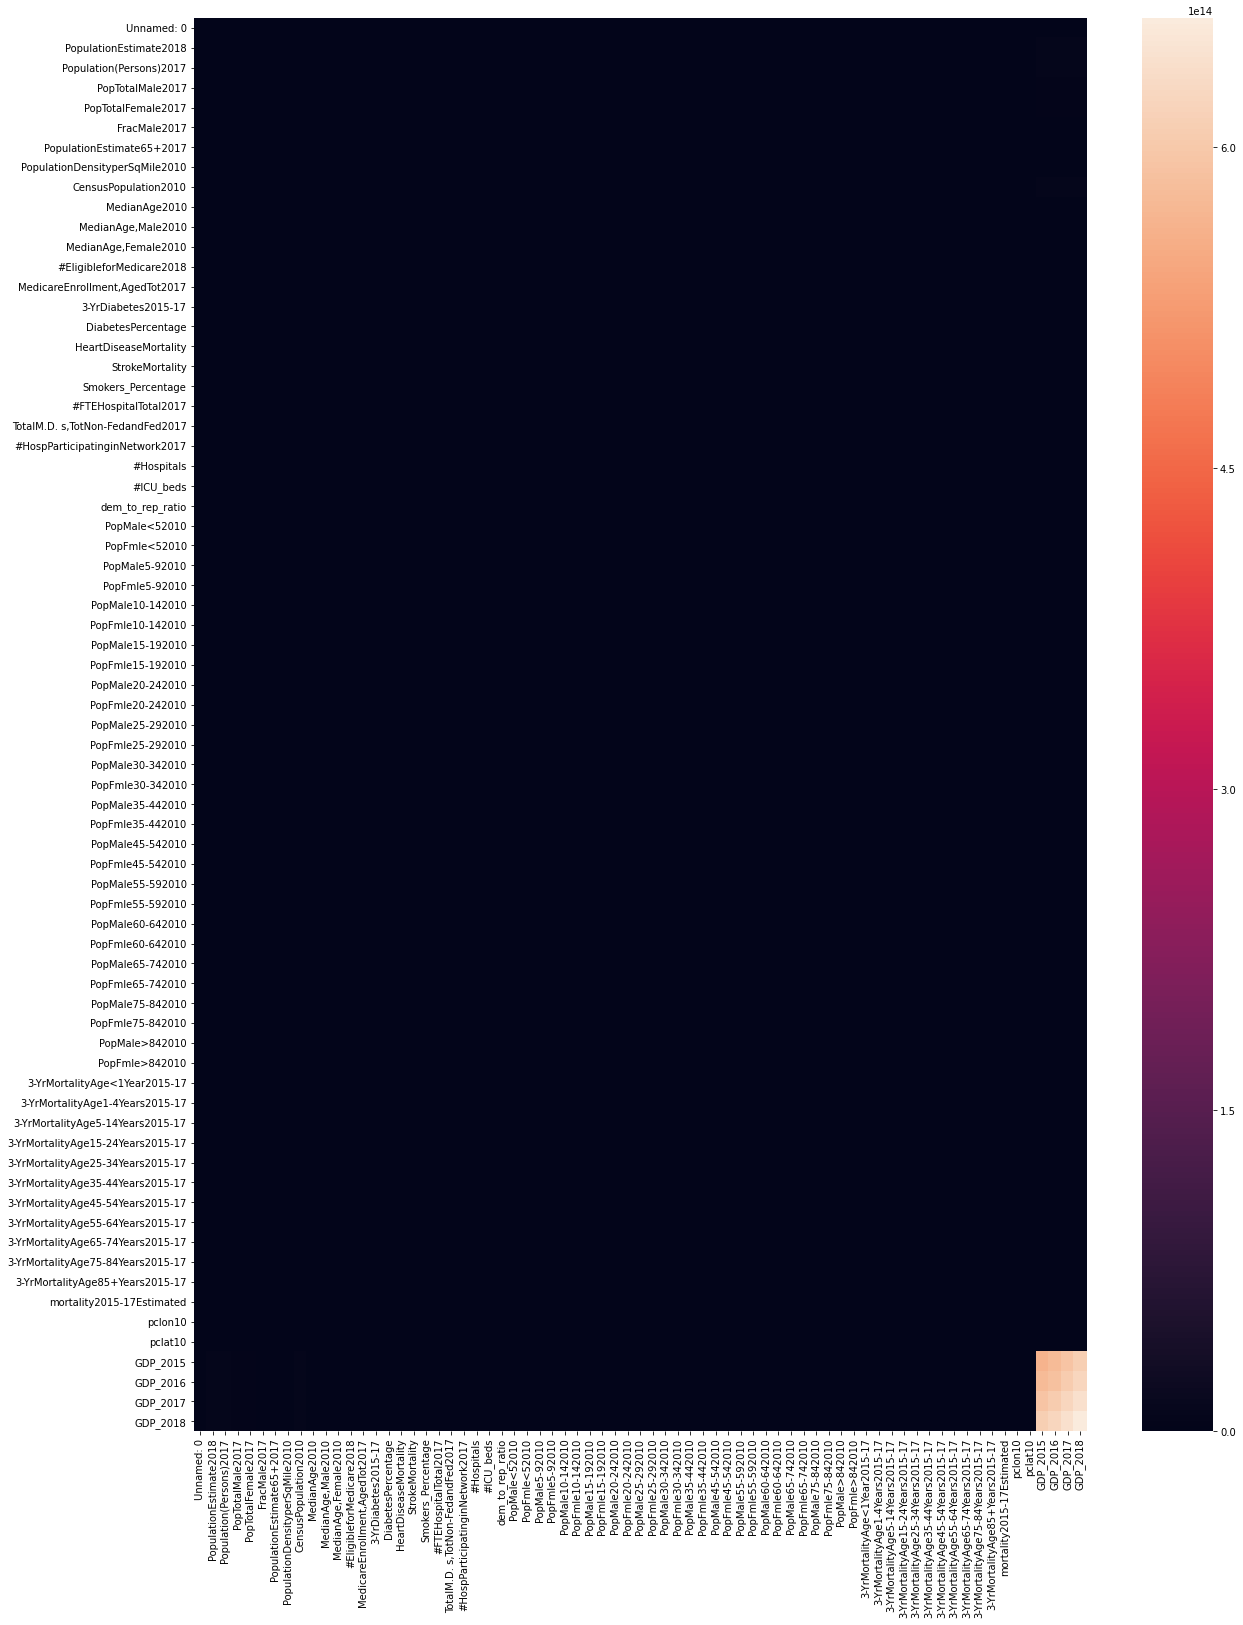

In [127]:
plt.figure(figsize=(20, 26))
#sn.heatmap(covMatrix, annot=True, fmt='g')
sn.heatmap(covMatrix, annot=False, fmt='g')
plt.show()

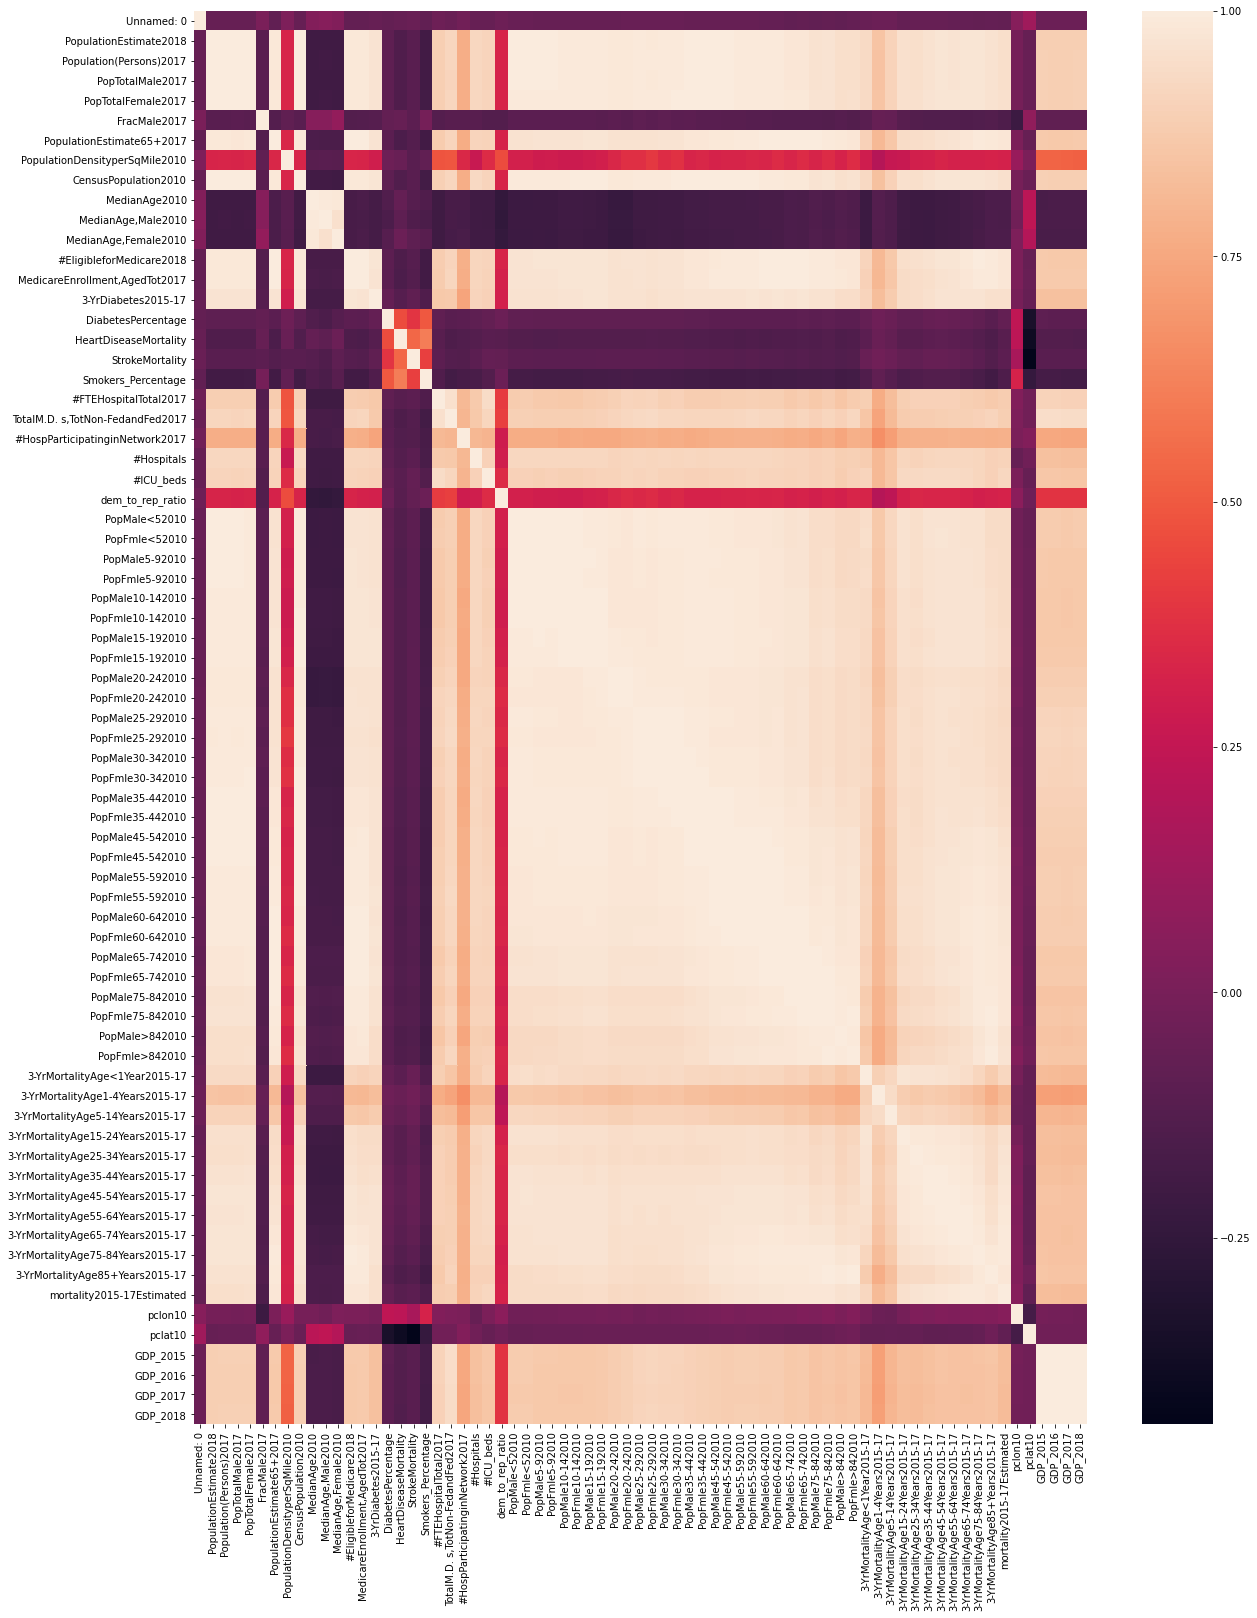

In [129]:
plt.figure(figsize=(20, 26))
sn.heatmap(corrMatrix, annot=False, fmt='g')
plt.show()

In [146]:
temp = np.array(data_static_zscore)
corrMatrix2 = np.corrcoef(np.transpose(temp))

In [194]:
#corr_avg = np.mean(np.abs(corrMatrix2)>0.5, axis = 1)
#corr_avg = np.median(np.abs(corrMatrix2), axis = 1)
corr_avg = np.percentile(np.abs(corrMatrix2), 90, axis = 1)
idx = np.argsort(corr_avg)
print(idx)

[14  4 64 16 15 65  8 17  9 10 23  6 19 53 54 18 21 22 20 52 69 68 67 66
 56 55 57 13 58 63 51 59 50 60 32 62 33 35 61 49 34 48 12 31 42 43 36 30
 46  5 25 24 47 11 37 26 27  0  2 44 41  1 40 45 28  3 29 38 39  7]


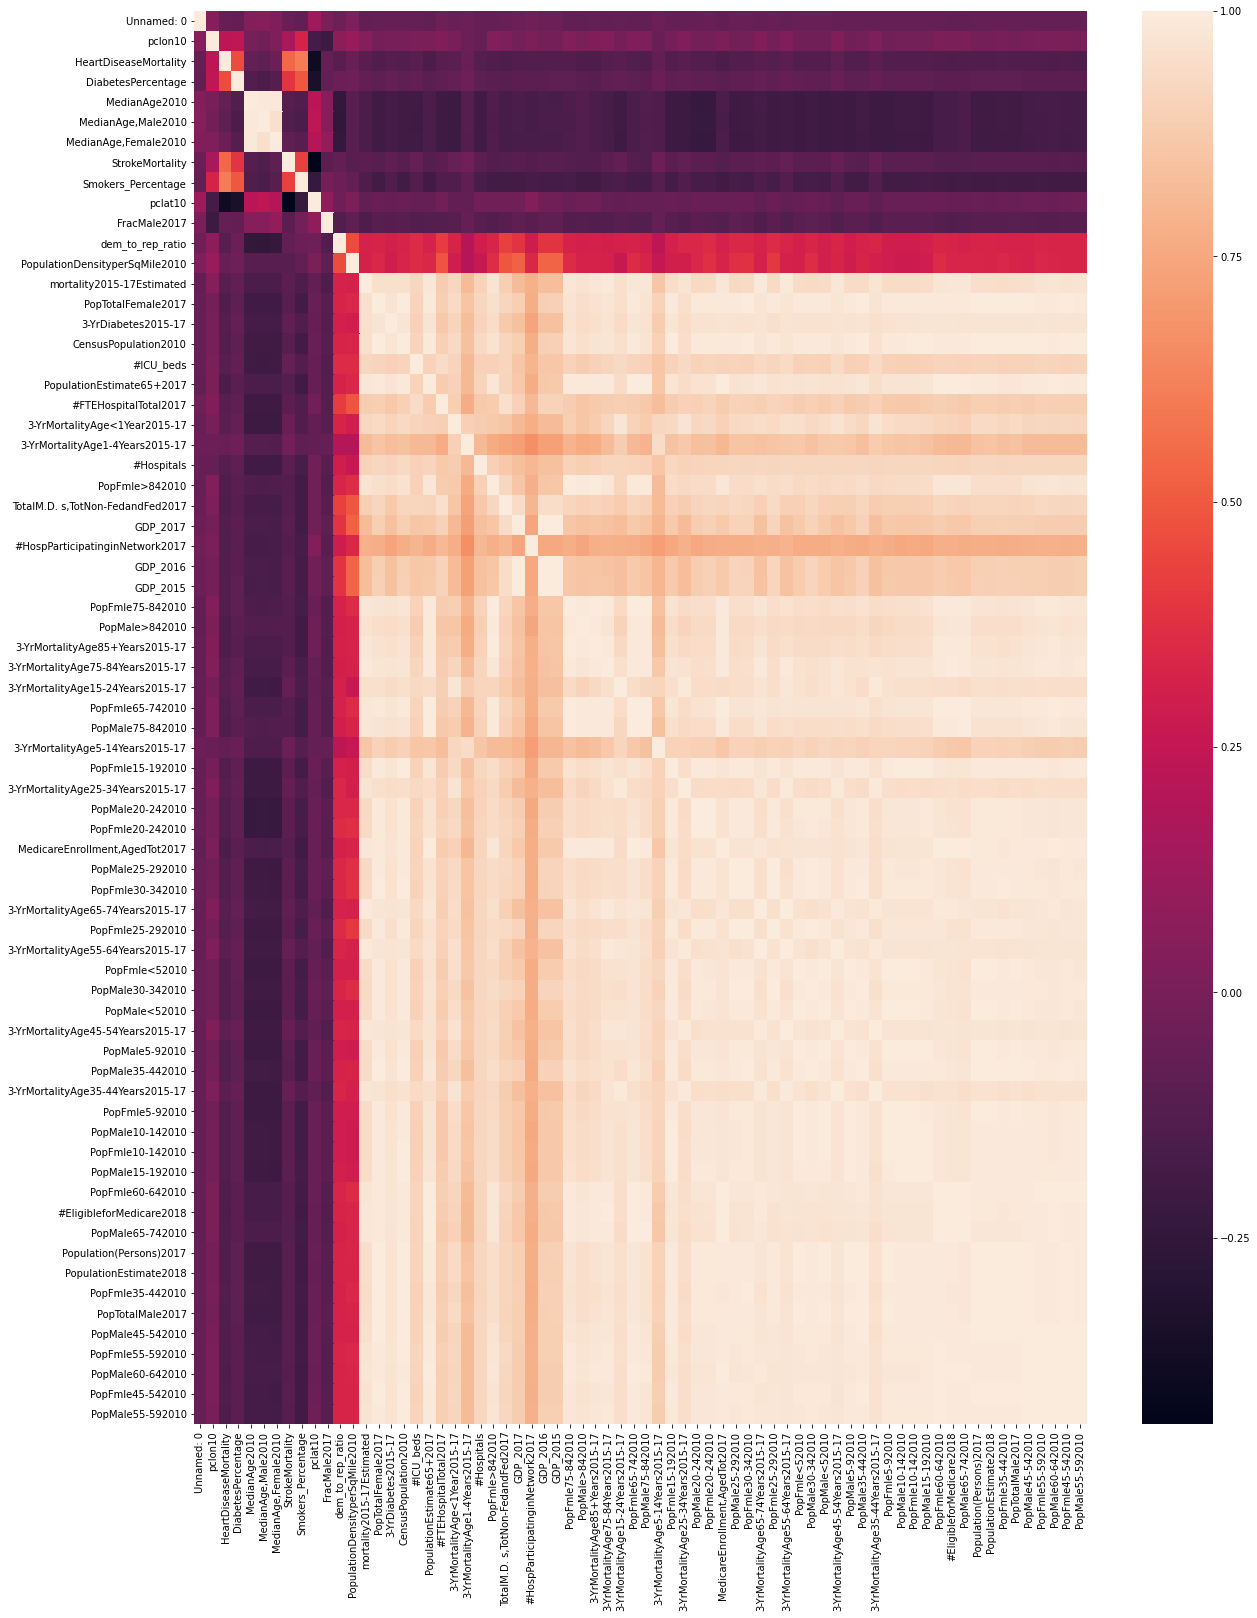

In [201]:
#df_berk2_reorder = df_berk2.reindex(df_berk2.columns[idx], axis=1)
columns_reorder = ['Unnamed: 0', 'pclon10', 'HeartDiseaseMortality', 'DiabetesPercentage','MedianAge2010', 'MedianAge,Male2010','MedianAge,Female2010',
                   'StrokeMortality', 'Smokers_Percentage', 'pclat10','FracMale2017', 'dem_to_rep_ratio', 'PopulationDensityperSqMile2010',
        'mortality2015-17Estimated', 'PopTotalFemale2017',
       '3-YrDiabetes2015-17', 
       'CensusPopulation2010', 
       '#ICU_beds', 'PopulationEstimate65+2017',
       '#FTEHospitalTotal2017', '3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '#Hospitals',
       'PopFmle>842010', 'TotalM.D. s,TotNon-FedandFed2017', 'GDP_2017',
       '#HospParticipatinginNetwork2017', 'GDP_2016', 'GDP_2015', 
       'PopFmle75-842010', 'PopMale>842010', '3-YrMortalityAge85+Years2015-17',
       '3-YrMortalityAge75-84Years2015-17',
       '3-YrMortalityAge15-24Years2015-17', 'PopFmle65-742010',
       'PopMale75-842010', '3-YrMortalityAge5-14Years2015-17',
       'PopFmle15-192010', '3-YrMortalityAge25-34Years2015-17',
       'PopMale20-242010', 'PopFmle20-242010',
       'MedicareEnrollment,AgedTot2017', 'PopMale25-292010',
       'PopFmle30-342010', '3-YrMortalityAge65-74Years2015-17',
       'PopFmle25-292010', '3-YrMortalityAge55-64Years2015-17',
       'PopFmle<52010', 'PopMale30-342010', 'PopMale<52010',
       '3-YrMortalityAge45-54Years2015-17', 'PopMale5-92010',
       'PopMale35-442010',
       '3-YrMortalityAge35-44Years2015-17', 'PopFmle5-92010',
       'PopMale10-142010', 'PopFmle10-142010', 'PopMale15-192010',
       'PopFmle60-642010', '#EligibleforMedicare2018',
       'PopMale65-742010', 'Population(Persons)2017', 
       'PopulationEstimate2018', 'PopFmle35-442010',
       'PopTotalMale2017', 
       'PopMale45-542010', 'PopFmle55-592010', 'PopMale60-642010',
       'PopFmle45-542010', 'PopMale55-592010']
df_berk2_reorder = df_berk2.reindex(columns_reorder, axis=1)
corrMatrix_reorder = df_berk2_reorder.corr()

plt.figure(figsize=(20, 26))
sn.heatmap(corrMatrix_reorder, annot=False, fmt='g')
plt.show()

In [196]:
df_berk2_reorder.columns

Index(['mortality2015-17Estimated', 'pclon10', 'PopTotalFemale2017',
       '3-YrDiabetes2015-17', 'HeartDiseaseMortality', 'DiabetesPercentage',
       'MedianAge2010', 'CensusPopulation2010', 'MedianAge,Male2010',
       'StrokeMortality', '#ICU_beds', 'PopulationEstimate65+2017',
       '#FTEHospitalTotal2017', '3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', 'Smokers_Percentage', '#Hospitals',
       'PopFmle>842010', 'TotalM.D. s,TotNon-FedandFed2017', 'GDP_2017',
       '#HospParticipatinginNetwork2017', 'GDP_2016', 'GDP_2015', 'pclat10',
       'PopFmle75-842010', 'PopMale>842010', '3-YrMortalityAge85+Years2015-17',
       '3-YrMortalityAge75-84Years2015-17',
       '3-YrMortalityAge15-24Years2015-17', 'PopFmle65-742010',
       'PopMale75-842010', '3-YrMortalityAge5-14Years2015-17',
       'PopFmle15-192010', '3-YrMortalityAge25-34Years2015-17',
       'PopMale20-242010', 'PopFmle20-242010',
       'MedicareEnrollment,AgedTot2017', 'PopMale25-292010',


In [202]:
from scipy.stats import pearsonr
from scipy.special import betainc

def corrcoef(matrix):
    r = np.corrcoef(matrix)
    rf = r[np.triu_indices(r.shape[0], 1)]
    df = matrix.shape[1] - 2
    ts = rf * rf * (df / (1 - rf * rf))
    pf = betainc(0.5 * df, 0.5, df / (df + ts))
    p = np.zeros(shape=r.shape)
    p[np.triu_indices(p.shape[0], 1)] = pf
    p[np.tril_indices(p.shape[0], -1)] = p.T[np.tril_indices(p.shape[0], -1)]
    p[np.diag_indices(p.shape[0])] = np.ones(p.shape[0])
    return r, p

temp = corrMatrix_reorder.to_numpy()
corrMatrix2, p = corrcoef(np.transpose(temp))

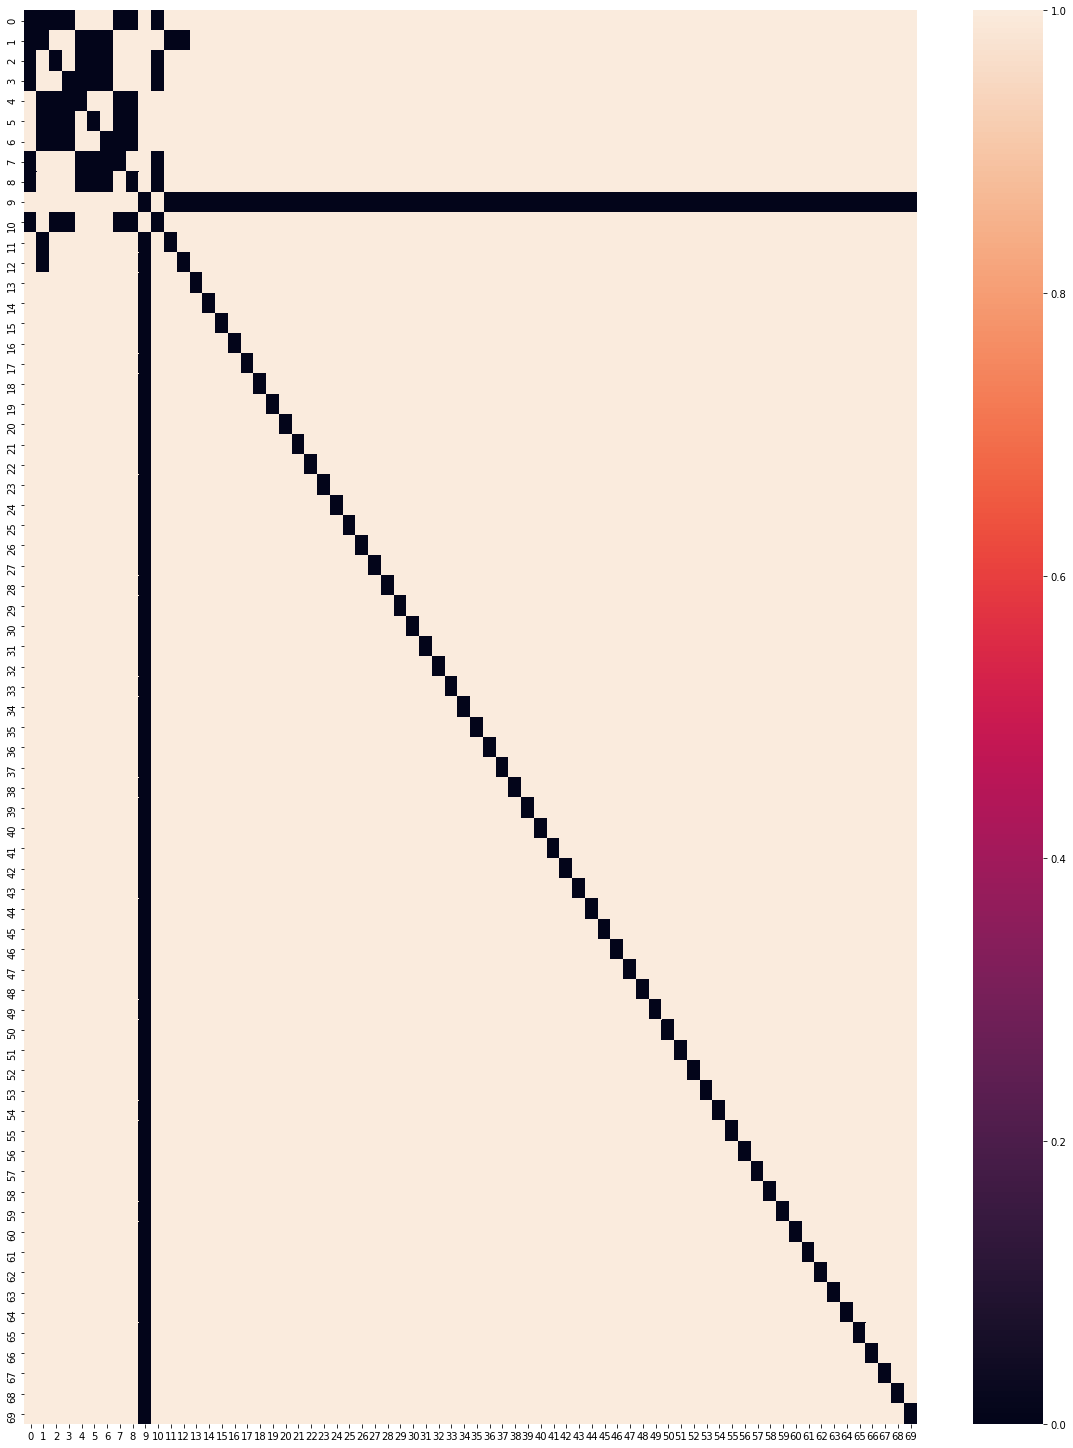

In [205]:
plt.figure(figsize=(20, 26))
sn.heatmap(p<0.05, annot=False, fmt='g')
plt.show()

## covariance & correlation marix with time-series data

In [214]:
temp = np.vstack(dataList_time)
corrMatrix_time = np.corrcoef(np.transpose(temp))

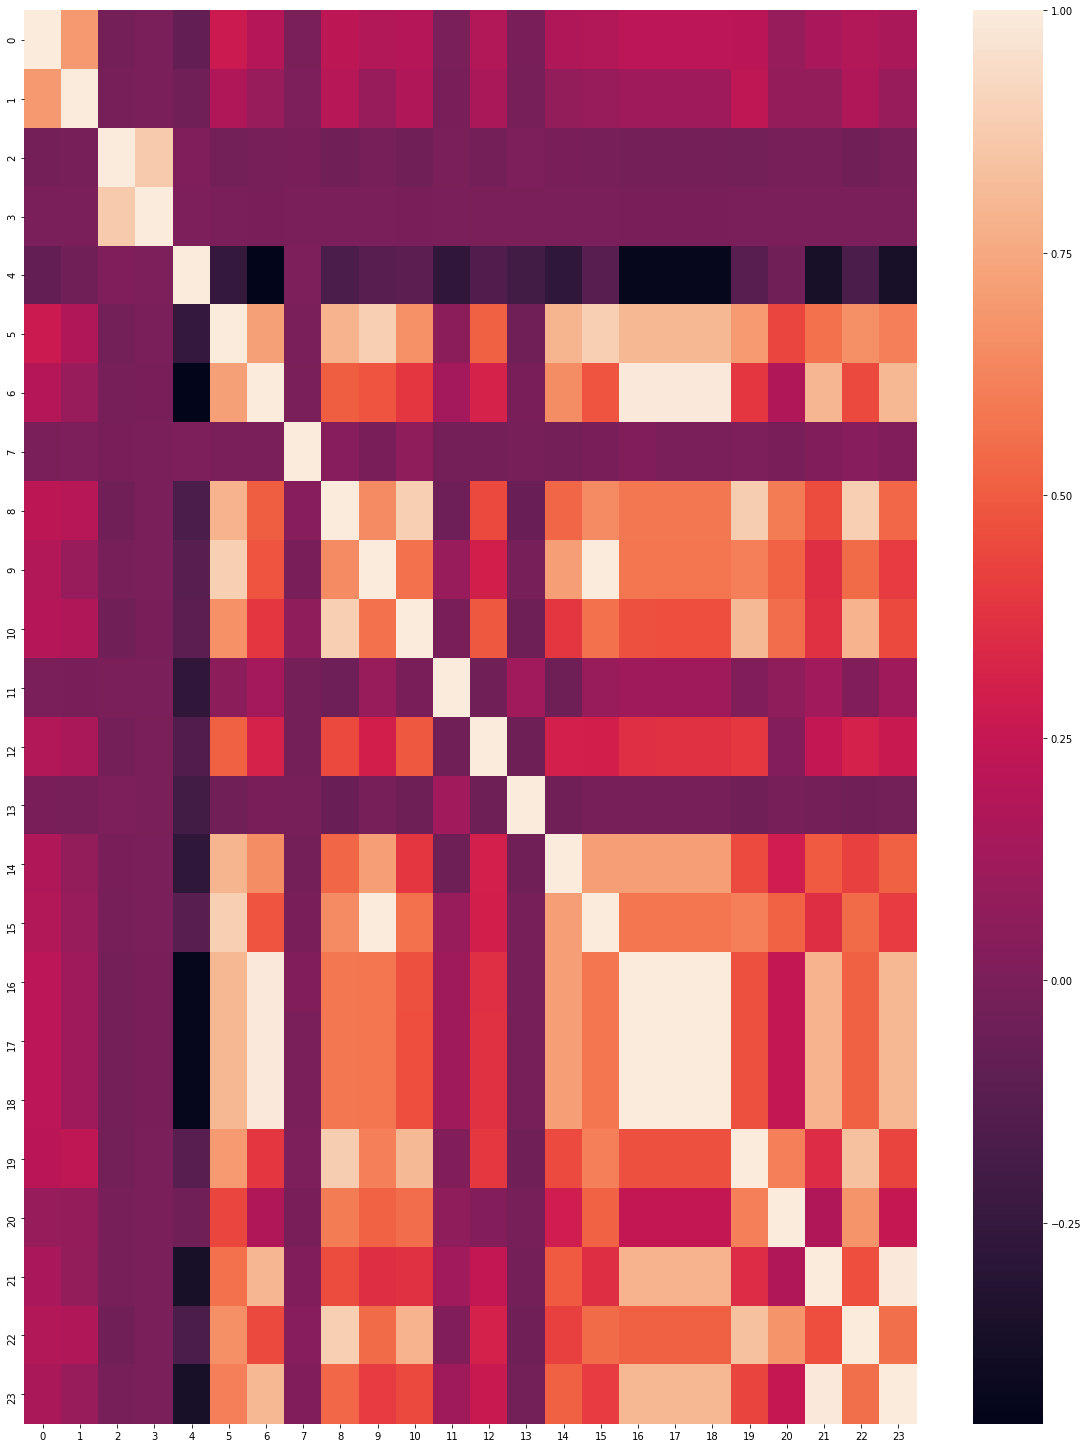

['cases', 'deaths', 'm50', 'm50_index', 'seasonality', 'positive', 'negative', 'pending', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease']


In [216]:
plt.figure(figsize=(20, 26))
sn.heatmap(corrMatrix_time, annot=False, fmt='g')
plt.show()
print(columns_time)

## Retrain the model with new static data

In [127]:
df_berk_withPCA = df_berk2.copy()
columns_lowCorr = ['pclon10', 'HeartDiseaseMortality', 'DiabetesPercentage','MedianAge2010', 'MedianAge,Male2010','MedianAge,Female2010',
                   'StrokeMortality', 'Smokers_Percentage', 'pclat10','FracMale2017', 'dem_to_rep_ratio', 'PopulationDensityperSqMile2010']
columns_highCorr = ['mortality2015-17Estimated', 'PopTotalFemale2017',
       '3-YrDiabetes2015-17', 
       'CensusPopulation2010', 
       '#ICU_beds', 'PopulationEstimate65+2017',
       '#FTEHospitalTotal2017', '3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '#Hospitals',
       'PopFmle>842010', 'TotalM.D. s,TotNon-FedandFed2017', 'GDP_2017',
       '#HospParticipatinginNetwork2017', 'GDP_2016', 'GDP_2015', 
       'PopFmle75-842010', 'PopMale>842010', '3-YrMortalityAge85+Years2015-17',
       '3-YrMortalityAge75-84Years2015-17',
       '3-YrMortalityAge15-24Years2015-17', 'PopFmle65-742010',
       'PopMale75-842010', '3-YrMortalityAge5-14Years2015-17',
       'PopFmle15-192010', '3-YrMortalityAge25-34Years2015-17',
       'PopMale20-242010', 'PopFmle20-242010',
       'MedicareEnrollment,AgedTot2017', 'PopMale25-292010',
       'PopFmle30-342010', '3-YrMortalityAge65-74Years2015-17',
       'PopFmle25-292010', '3-YrMortalityAge55-64Years2015-17',
       'PopFmle<52010', 'PopMale30-342010', 'PopMale<52010',
       '3-YrMortalityAge45-54Years2015-17', 'PopMale5-92010',
       'PopMale35-442010',
       '3-YrMortalityAge35-44Years2015-17', 'PopFmle5-92010',
       'PopMale10-142010', 'PopFmle10-142010', 'PopMale15-192010',
       'PopFmle60-642010', '#EligibleforMedicare2018',
       'PopMale65-742010', 'Population(Persons)2017', 
       'PopulationEstimate2018', 'PopFmle35-442010',
       'PopTotalMale2017', 
       'PopMale45-542010', 'PopFmle55-592010', 'PopMale60-642010',
       'PopFmle45-542010', 'PopMale55-592010']

df_berk_befPCA = df_berk_withPCA[columns_highCorr]
df_berk_withPCA = df_berk_withPCA[columns_lowCorr]

In [128]:
# run PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# df_berk_befPCA_np = df_berk_befPCA.to_numpy()
# df_berk_befPCA_np.shape
df_berk_befPCA = StandardScaler().fit_transform(df_berk_befPCA)
pca = PCA(.999)
pc = pca.fit_transform(df_berk_befPCA)

In [129]:
print(pc.shape)
test = pd.DataFrame(pc)
test.index = df_berk_withPCA.index
test.columns = ['pc%d' % (x) for x in range(0,18)]
test.head()
#pc.shape
#dataList_static, fips_noData_static, fips_final_static = concatDF_static(df_berk2, columns_demo, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])

#df_berk_withPCA = pd.concat([df_berk_withPCA, pd.DataFrame(pc)], axis=1)
#df_berk_withPCA.join(pd.DataFrame(pc))
df_berk_withPCA = pd.concat([df_berk_withPCA, test], axis=1)
df_berk_withPCA.head()

(3113, 18)


,pclon10,HeartDiseaseMortality,DiabetesPercentage,MedianAge2010,"MedianAge,Male2010","MedianAge,Female2010",StrokeMortality,Smokers_Percentage,pclat10,FracMale2017,...,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17
countyFIPS,,,,,,,,,,,,,,,,,,,,,
01001,-86.494165,204.5,9.9,37.0,35.9,37.9,56.1,18.081557,32.500389,0.486578,...,-0.051440,0.046641,0.037642,0.130746,0.031407,0.090717,0.004226,-0.025012,0.065763,-0.054134
01003,-87.762381,183.2,8.5,41.1,40.1,42.2,41.9,17.489033,30.548923,0.485472,...,0.242081,-0.149226,-0.163714,0.288925,0.169704,-0.336700,0.068208,-0.018095,-0.136203,0.121896
01005,-85.310038,220.4,15.7,39.0,37.2,41.6,49.0,21.999985,31.844036,0.527701,...,0.038018,-0.038875,-0.021113,0.014349,0.064904,-0.010696,0.010003,-0.070605,-0.033789,0.049312
01007,-87.127659,225.5,13.3,37.8,36.5,39.5,57.2,19.114200,33.030921,0.535469,...,0.024051,-0.072956,0.004493,0.032162,0.053402,0.005343,0.000336,-0.053591,-0.027796,0.044010
01009,-86.591491,224.8,14.9,39.0,38.0,40.0,52.8,19.208672,33.955243,0.493114,...,-0.034623,0.010812,-0.045204,0.047260,0.136343,0.050106,0.166609,0.087799,0.090388,0.156895


In [130]:
pcaList = ['pc%d' % (x) for x in range(0,18)]
columns_aftPCA = columns_lowCorr + pcaList
print(columns_aftPCA)

dataList_static_PCA, fips_noData_static_PCA, fips_final_static_PCA = concatDF_static(
    df_berk_withPCA, columns_aftPCA, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])

['pclon10', 'HeartDiseaseMortality', 'DiabetesPercentage', 'MedianAge2010', 'MedianAge,Male2010', 'MedianAge,Female2010', 'StrokeMortality', 'Smokers_Percentage', 'pclat10', 'FracMale2017', 'dem_to_rep_ratio', 'PopulationDensityperSqMile2010', 'pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17']
fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not found
fips  02261 not found
fips  02290 not found
fips  08014 not found
fips  46102 not found


In [131]:
#print(dataList_static_PCA[1])
#print(df_berk_withPCA.iloc[0, 9:])
test = df_berk_withPCA.loc[:, 'HeartDiseaseMortality'].to_numpy()

In [46]:
# normalization
data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)
data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

# for static dataset
inputSize = 7
trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

# for timeseries dataset
columns_time = columns_mortality + columns_mobility + columns_season + columns_testResult
trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time)

# unnormalize the targets
normalizeTarget = False

if not normalizeTarget:
    trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time, 'deaths')

In [49]:
print(trainingData_time)

[[[-0.13225302 -0.11403075  0.02497085 ... -0.53817743 -0.4824072
   -0.56392854]
  [-0.13225302 -0.11403075  0.25009263 ... -0.53817743 -0.4824072
   -0.56392854]
  [-0.13225302 -0.11403075  0.22810724 ... -0.53817743 -0.4824072
   -0.56392854]
  ...
  [-0.13225302 -0.11403075  0.25228506 ... -0.53817743 -0.4824072
   -0.56392854]
  [-0.13225302 -0.11403075  0.32557982 ... -0.53817743 -0.4824072
   -0.56392854]
  [-0.13225302 -0.11403075  0.15797935 ... -0.53817743 -0.4824072
   -0.56392854]]

 [[-0.13225302 -0.11403075  0.25009263 ... -0.53817743 -0.4824072
   -0.56392854]
  [-0.13225302 -0.11403075  0.22810724 ... -0.53817743 -0.4824072
   -0.56392854]
  [-0.13225302 -0.11403075  0.22856401 ... -0.53817743 -0.4824072
   -0.56392854]
  ...
  [-0.13225302 -0.11403075  0.32557982 ... -0.53817743 -0.4824072
   -0.56392854]
  [-0.13225302 -0.11403075  0.15797935 ... -0.53817743 -0.4824072
   -0.56392854]
  [-0.13225302 -0.11403075  0.06504393 ... -0.53817743 -0.4824072
   -0.56392854]]



In [50]:
# train the model
quantile = 0.5
num_epoch = 17

NUM_CELLS = 128
NUM_DAYS_OUT = 14

num_repeat = 5
modelList = []
hisoryList = []

for rep in range(num_repeat):
    model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
    model.call([trainingData_time, trainingData_static])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
    history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
              validation_data=([testingData_time, testingData_static], testingAns_time),
              epochs=num_epoch, shuffle=True, batch_size=64)
    modelList.append(model)
    hisoryList.append(history)
    

Train on 136770 samples, validate on 2910 samples
Epoch 1/17
136770/136770 [==============================] - 10s 73us/sample - loss: 0.1265 - val_loss: 0.2136
Epoch 2/17
136770/136770 [==============================] - 9s 69us/sample - loss: 0.1080 - val_loss: 0.2015
Epoch 3/17
136770/136770 [==============================] - 10s 70us/sample - loss: 0.1025 - val_loss: 0.1983
Epoch 4/17
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0993 - val_loss: 0.1917
Epoch 5/17
136770/136770 [==============================] - 9s 69us/sample - loss: 0.0973 - val_loss: 0.1991
Epoch 6/17
136770/136770 [==============================] - 9s 69us/sample - loss: 0.0961 - val_loss: 0.1871
Epoch 7/17
136770/136770 [==============================] - 9s 68us/sample - loss: 0.0953 - val_loss: 0.1903
Epoch 8/17
136770/136770 [==============================] - 9s 69us/sample - loss: 0.0945 - val_loss: 0.1853
Epoch 9/17
136770/136770 [==============================] - 10s 70us/sample

In [52]:
# save trained models and histories
import pickle
for i in range(5):
    name = "models_0.5quantile, 5models, 17maxEpoch_%d_withPCAonStatic" % (i)
    modelList[i].save_weights(name, save_format="tf")

# output = open('models_50%quantile, 10models, 15maxEpoch.pkl', 'wb')
# pickle.dump(modelList_featureTest, output)
# output.close()

In [54]:
# get validation error after shuffling each colunm - demographic data
print(testingData_static.shape)
num_repeat = 100
featureTest_valLoss_static = []
for i in range(testingData_static.shape[1]):
    featureTest_valLoss_static.append([])
    for rep in range(num_repeat):
        testingData_static_shuffle = testingData_static.copy()
        testingData_static_shuffle[:, i] = np.random.permutation(testingData_static_shuffle[:, i])
        prediction_temp = [x.predict([testingData_time, testingData_static_shuffle]) for x in modelList]
        featureTest_valLoss_static[-1].append( [np.mean(abs(x-testingAns_time))/2 for x in prediction_temp] )
    print(i, ". ", columns_demo[i], ": validation loss = ", np.mean(featureTest_valLoss_static[-1]))
    
# get validation error after shuffling each colunm - time-series data
print(testingData_time.shape)
num_repeat = 100
featureTest_valLoss_time = []
for i in range(testingData_time.shape[2]):
    featureTest_valLoss_time.append([])
    for rep in range(num_repeat):
        testingData_time_shuffle = testingData_time.copy()
        testingData_time_shuffle[:, :, i] = np.random.permutation(testingData_time_shuffle[:, :, i])
        prediction_temp = [x.predict([testingData_time_shuffle, testingData_static]) for x in modelList]
        featureTest_valLoss_time[-1].append( [np.mean(abs(x-testingAns_time))/2 for x in prediction_temp] )
    print(i, ". ", columns_time[i], ": validation loss = ", np.mean(featureTest_valLoss_time[-1]))    

(2910, 30)
0 .  PopulationEstimate2018 : validation loss =  0.2004956629872322
1 .  Population(Persons)2017 : validation loss =  0.203733855843544
2 .  PopTotalMale2017 : validation loss =  0.20021747240424156
3 .  PopTotalFemale2017 : validation loss =  0.19988896095752717
4 .  FracMale2017 : validation loss =  0.20042050594091415
5 .  PopulationEstimate65+2017 : validation loss =  0.2001060094833374
6 .  PopulationDensityperSqMile2010 : validation loss =  0.19956470018625258
7 .  CensusPopulation2010 : validation loss =  0.20138317859172822
8 .  MedianAge2010 : validation loss =  0.2003557358086109
9 .  MedianAge,Male2010 : validation loss =  0.20026353871822358
10 .  MedianAge,Female2010 : validation loss =  0.20118388974666596
11 .  #EligibleforMedicare2018 : validation loss =  0.19685940515995026
12 .  MedicareEnrollment,AgedTot2017 : validation loss =  0.21473160365223884
13 .  3-YrDiabetes2015-17 : validation loss =  0.19852242296934128
14 .  DiabetesPercentage : validation loss

In [55]:
# save the data - demographic data
import pickle
featureTest_valLoss_static_np = np.array(featureTest_valLoss_static)
my_data = {'feature name': columns_aftPCA,
           'validation loss': featureTest_valLoss_static_np}
output = open('featureImportanceAnalysis_static_aftPCA.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

# load the data
# import pprint
# pkl_file = open('featureImportanceAnalysis_static.pkl', 'rb')
# my_data = pickle.load(pkl_file)
# # pprint.pprint(my_data)
# pkl_file.close()

In [59]:
val_loss_mae = np.array([ y.history['val_loss'] for y in hisoryList])
val_loss_mae_std = np.std(val_loss_mae, axis = 0)
val_loss_mae_avg = np.mean(val_loss_mae, axis = 0)
val_loss_mae_avg.shape

(17,)

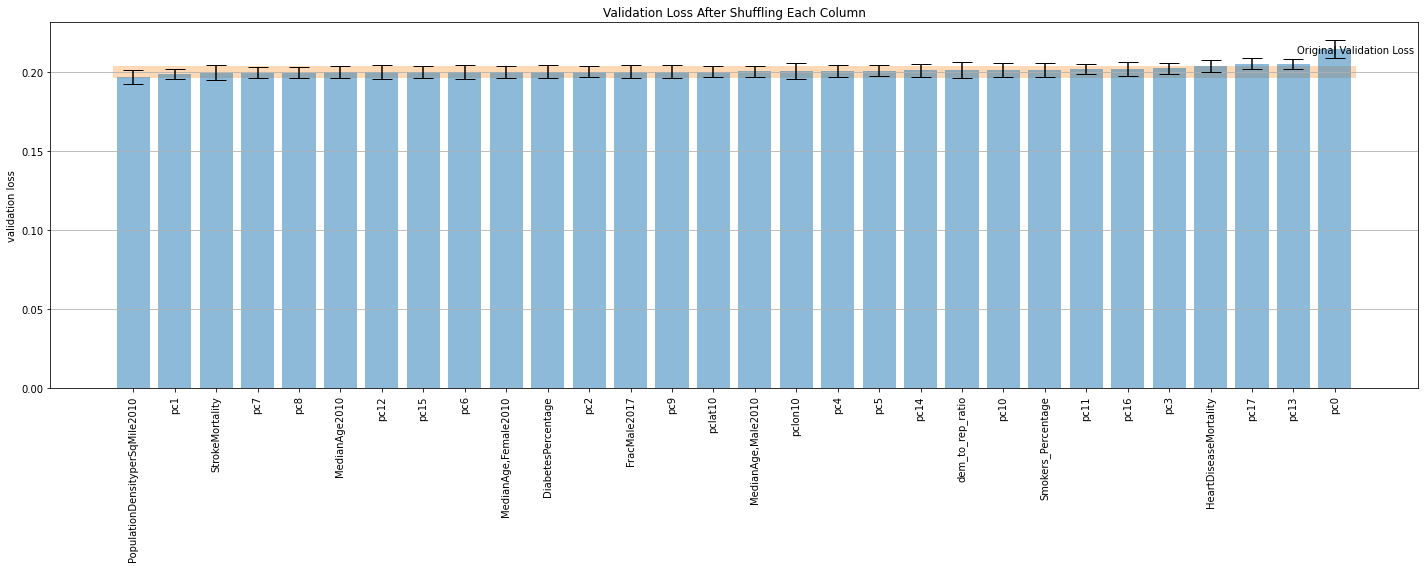

In [83]:
# plot the validation loss - demographic data
featureTest_valLoss_static_mean = [ np.mean(featureTest_valLoss_static_np[x,:,:]) for x in range(len(columns_aftPCA)) ]
featureTest_valLoss_static_std = [ np.std(featureTest_valLoss_static_np[x,:,:]) for x in range(len(columns_aftPCA)) ]

x_pos = np.arange(len(columns_aftPCA))

idx_static = np.array(np.argsort(featureTest_valLoss_static_mean))

fig, ax = plt.subplots()
fig.set_size_inches(20,8) 
ax.bar(x_pos, [featureTest_valLoss_static_mean[i] for i in idx_static],
       yerr=[featureTest_valLoss_static_std[i] for i in idx_static],
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('validation loss')
ax.set_xticks(x_pos)
ax.set_xticklabels([columns_aftPCA[i] for i in idx_static], rotation='vertical')
ax.set_title('Validation Loss After Shuffling Each Column')
ax.yaxis.grid(True)

# add line for validation loss of original model
yerr_pos = val_loss_mae_avg[-1]+val_loss_mae_std[-1]
yerr_neg = val_loss_mae_avg[-1]-val_loss_mae_std[-1]
ax.fill_between([-0.5, len(x_pos)-0.5], [yerr_pos, yerr_pos], [yerr_neg, yerr_neg], alpha = 0.3)
ax.text(len(x_pos)-0.5, yerr_pos+0.01, 'Original Validation Loss', horizontalalignment='center', verticalalignment='center')

# Save the figure and show
plt.tight_layout()
plt.savefig('featureTest_valLoss_static.png')
plt.show()

In [61]:
# save the data - time-series data
import pickle
featureTest_valLoss_time_np = np.array(featureTest_valLoss_time)
my_data = {'feature name': columns_time,
           'validation loss': featureTest_valLoss_time_np}
output = open('featureImportanceAnalysis_time_withStaticAftPCA.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

# load the data
# import pprint
# pkl_file = open('featureImportanceAnalysis_static.pkl', 'rb')
# my_data = pickle.load(pkl_file)
# # pprint.pprint(my_data)
# pkl_file.close()

(24, 100, 5)


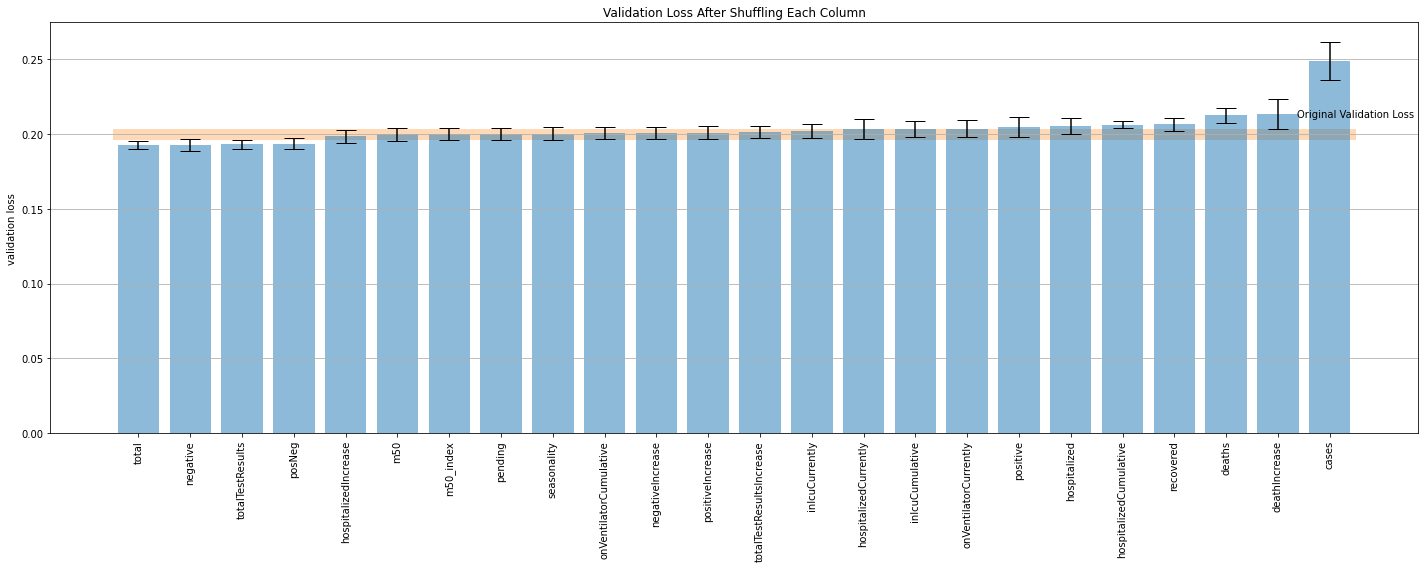

In [84]:
# plot the validation loss - time-series data
print(featureTest_valLoss_time_np.shape)
featureTest_valLoss_time_mean = [ np.mean(featureTest_valLoss_time_np[x,:,:]) for x in range(len(columns_time)) ]
featureTest_valLoss_time_std = [ np.std(featureTest_valLoss_time_np[x,:,:]) for x in range(len(columns_time)) ]

x_pos = np.arange(len(columns_time))

idx_time = np.array(np.argsort(featureTest_valLoss_time_mean))

fig, ax = plt.subplots()
fig.set_size_inches(20,8) 
ax.bar(x_pos, [featureTest_valLoss_time_mean[i] for i in idx_time],
       yerr= [featureTest_valLoss_time_std[i] for i in idx_time],
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('validation loss')
ax.set_xticks(x_pos)
ax.set_xticklabels([columns_time[i] for i in idx_time], rotation='vertical')
ax.set_title('Validation Loss After Shuffling Each Column')
ax.yaxis.grid(True)

# add line for validation loss of original model
yerr_pos = val_loss_mae_avg[-1]+val_loss_mae_std[-1]
yerr_neg = val_loss_mae_avg[-1]-val_loss_mae_std[-1]
ax.fill_between([-0.5, len(x_pos)-0.5], [yerr_pos, yerr_pos], [yerr_neg, yerr_neg], alpha = 0.3)
ax.text(len(x_pos)-0.5, yerr_pos+0.01, 'Original Validation Loss', horizontalalignment='center', verticalalignment='center')

# Save the figure and show
plt.tight_layout()
plt.savefig('featureTest_valLoss_time.png')
plt.show()

In [75]:
print(idx)
test = featureTest_valLoss_time_mean[idx]

[16  6 17 18 20  2  3  7  4 13 21 22 23 10  8 11 12  5 15  9 14  1 19  0]


TypeError: only integer scalar arrays can be converted to a scalar index

## Retrain the model with selected features

In [156]:
sortedFeatures_static = [columns_aftPCA[i] for i in idx_static]
sortedFeatures_time = [columns_time[i] for i in idx_time]

inputSize = 7
normalizeTarget = False

quantile = 0.5
num_epoch = 25

NUM_CELLS = 128
NUM_DAYS_OUT = 14

num_repeat = 2
modelList = []
historyList = []

for i_static in range(10):
    modelList.append([])
    historyList.append([])
    
    numRemove_static = 10+i_static*2
    columns_static_selected = sortedFeatures_static[numRemove_static:]

    # choose features from static data
    dataList_static_PCA, fips_noData_static_PCA, fips_final_static_PCA = concatDF_static(
        df_berk_withPCA, columns_static_selected, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])
    
    # normzliation
    data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)

    # for static dataset
    trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

    for i_time in range(5):
        modelList[-1].append([])
        historyList[-1].append([])
        
        numRemove_time = 10+i_time*2   
        
        columns_time_selected = sortedFeatures_time[numRemove_time:]

        # choose features from time-series data
        columns_mortality = ['cases', 'deaths']
        columns_mobility = ['m50', 'm50_index']
        columns_season = ['seasonality']
        columns_testResult = ['positive', 'negative', 'pending', 'hospitalizedCurrently',
               'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
               'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 
               'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease',
               'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
               'totalTestResultsIncrease'] 
        columns_mortality_tmp = [ x for x in columns_mortality if x in columns_time_selected]
        columns_mobility_tmp = [ x for x in columns_mobility if x in columns_time_selected]
        columns_season_tmp = [ x for x in columns_season if x in columns_time_selected]
        columns_testResult_tmp = [ x for x in columns_testResult if x in columns_time_selected]
        columns_time_selected_reorder = columns_mortality_tmp+columns_mobility_tmp+columns_season_tmp+columns_testResult_tmp
        dataList_time, fips_noData_time, fips_final_time = concatDF_timeseries(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, df_testResult_eachCounty,
                                                                 columns_mortality_tmp, columns_mobility_tmp, columns_season_tmp, columns_testResult_tmp,
                                                                 fipsList, df_fips2state, df_berk2, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 0)

        # normalization
        data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

        # for timeseries dataset
        trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time_selected_reorder)

        # unnormalize the targets
        if not normalizeTarget:
            trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time_selected_reorder, 'deaths')

            
        # train the model
        for rep in range(num_repeat):
            model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
            model.call([trainingData_time, trainingData_static])
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
            history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
                      validation_data=([testingData_time, testingData_static], testingAns_time),
                      epochs=num_epoch, shuffle=True, batch_size=64)
            modelList[-1][-1].append(model)
            historyList[-1][-1].append(history)
            

fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not found
fips  02261 not found
fips  02290 not found
fips  08014 not found
fips  46102 not found
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.1259 - val_loss: 0.1855
Epoch 2/25
136770/136770 [==============================] - 11s 82us/sample - loss: 0.1090 - val_loss: 0.1982
Epoch 3/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.1037 - val_loss: 0.1793
Epoch 4/25
136770/136770 [==============================] - 11s 82us/sample - loss: 0.1004 - val_loss: 0.1939
Epoch 5/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0985 - val_loss: 0.1796
Epoch 6/25
136770/136770 [

Epoch 18/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0904 - val_loss: 0.1792
Epoch 19/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0901 - val_loss: 0.1807
Epoch 20/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0898 - val_loss: 0.1833
Epoch 21/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0893 - val_loss: 0.1825
Epoch 22/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0891 - val_loss: 0.1795
Epoch 23/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0887 - val_loss: 0.1836
Epoch 24/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0883 - val_loss: 0.1793
Epoch 25/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0882 - val_loss: 0.1788
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 12

136770/136770 [==============================] - 12s 88us/sample - loss: 0.0945 - val_loss: 0.1830
Epoch 10/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0939 - val_loss: 0.1776
Epoch 11/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0936 - val_loss: 0.1794
Epoch 12/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0932 - val_loss: 0.1772
Epoch 13/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0928 - val_loss: 0.1735
Epoch 14/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0924 - val_loss: 0.1756
Epoch 15/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0920 - val_loss: 0.1765
Epoch 16/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0916 - val_loss: 0.1731
Epoch 17/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0914 - val_loss: 0.1750
Epoch 18/25
1

Epoch 7/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0966 - val_loss: 0.1844
Epoch 8/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0958 - val_loss: 0.1834
Epoch 9/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0951 - val_loss: 0.1896
Epoch 10/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0945 - val_loss: 0.1826
Epoch 11/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0942 - val_loss: 0.1762
Epoch 12/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0936 - val_loss: 0.1866
Epoch 13/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0932 - val_loss: 0.1766
Epoch 14/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0926 - val_loss: 0.1782
Epoch 15/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0923 - val_loss: 0.1827
Epoc

fips  08014 not found
fips  46102 not found
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.1258 - val_loss: 0.1824
Epoch 2/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.1091 - val_loss: 0.1801
Epoch 3/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.1038 - val_loss: 0.1891
Epoch 4/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.1008 - val_loss: 0.1829
Epoch 5/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0985 - val_loss: 0.1822
Epoch 6/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0971 - val_loss: 0.1804
Epoch 7/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0962 - val_loss: 0.1791
Epoch 8/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0953 - val_loss: 0.1835
Epoch 9/25
136770/136770 [

Epoch 21/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0898 - val_loss: 0.1793
Epoch 22/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0894 - val_loss: 0.1794
Epoch 23/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0891 - val_loss: 0.1775
Epoch 24/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0888 - val_loss: 0.1802
Epoch 25/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0883 - val_loss: 0.1744
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.1248 - val_loss: 0.1916
Epoch 2/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.1090 - val_loss: 0.1967
Epoch 3/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.1037 - val_loss: 0.1904
Epoch 4/25
136770/136770 [==============================] - 12s 8

136770/136770 [==============================] - 12s 85us/sample - loss: 0.0934 - val_loss: 0.1872
Epoch 13/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0930 - val_loss: 0.1862
Epoch 14/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0927 - val_loss: 0.1793
Epoch 15/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0922 - val_loss: 0.1903
Epoch 16/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0919 - val_loss: 0.1903
Epoch 17/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0916 - val_loss: 0.1855
Epoch 18/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0911 - val_loss: 0.1857
Epoch 19/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0909 - val_loss: 0.1871
Epoch 20/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0905 - val_loss: 0.1899
Epoch 21/25
1

Epoch 10/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0947 - val_loss: 0.1747
Epoch 11/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0942 - val_loss: 0.1749
Epoch 12/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0936 - val_loss: 0.1711
Epoch 13/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0933 - val_loss: 0.1792
Epoch 14/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0928 - val_loss: 0.1721
Epoch 15/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0925 - val_loss: 0.1758
Epoch 16/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0920 - val_loss: 0.1786
Epoch 17/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0916 - val_loss: 0.1757
Epoch 18/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0911 - val_loss: 0.1711
E

136770/136770 [==============================] - 12s 87us/sample - loss: 0.1264 - val_loss: 0.1920
Epoch 2/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.1097 - val_loss: 0.1807
Epoch 3/25
136770/136770 [==============================] - 11s 82us/sample - loss: 0.1045 - val_loss: 0.1807
Epoch 4/25
136770/136770 [==============================] - 11s 82us/sample - loss: 0.1010 - val_loss: 0.1818
Epoch 5/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0990 - val_loss: 0.1769
Epoch 6/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0977 - val_loss: 0.1820
Epoch 7/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0966 - val_loss: 0.1812
Epoch 8/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0958 - val_loss: 0.1787
Epoch 9/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0953 - val_loss: 0.1820
Epoch 10/25
136770/13

Epoch 22/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0901 - val_loss: 0.1968
Epoch 23/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0897 - val_loss: 0.1860
Epoch 24/25
136770/136770 [==============================] - 12s 84us/sample - loss: 0.0893 - val_loss: 0.1884
Epoch 25/25
136770/136770 [==============================] - 11s 84us/sample - loss: 0.0890 - val_loss: 0.1921
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 12s 84us/sample - loss: 0.1267 - val_loss: 0.2056
Epoch 2/25
136770/136770 [==============================] - 11s 80us/sample - loss: 0.1103 - val_loss: 0.1952
Epoch 3/25
136770/136770 [==============================] - 11s 82us/sample - loss: 0.1047 - val_loss: 0.1855
Epoch 4/25
136770/136770 [==============================] - 11s 80us/sample - loss: 0.1015 - val_loss: 0.1841
Epoch 5/25
136770/136770 [==============================] - 11s 80

136770/136770 [==============================] - 11s 78us/sample - loss: 0.0932 - val_loss: 0.1704
Epoch 14/25
136770/136770 [==============================] - 11s 78us/sample - loss: 0.0928 - val_loss: 0.1758
Epoch 15/25
136770/136770 [==============================] - 11s 78us/sample - loss: 0.0924 - val_loss: 0.1809
Epoch 16/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.0920 - val_loss: 0.1720
Epoch 17/25
136770/136770 [==============================] - 11s 78us/sample - loss: 0.0914 - val_loss: 0.1745
Epoch 18/25
136770/136770 [==============================] - 11s 78us/sample - loss: 0.0909 - val_loss: 0.1772
Epoch 19/25
136770/136770 [==============================] - 11s 78us/sample - loss: 0.0905 - val_loss: 0.1917
Epoch 20/25
136770/136770 [==============================] - 11s 78us/sample - loss: 0.0900 - val_loss: 0.1707
Epoch 21/25
136770/136770 [==============================] - 11s 78us/sample - loss: 0.0894 - val_loss: 0.1704
Epoch 22/25
1

Epoch 11/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0946 - val_loss: 0.1779
Epoch 12/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0941 - val_loss: 0.1798
Epoch 13/25
136770/136770 [==============================] - 10s 77us/sample - loss: 0.0936 - val_loss: 0.1827
Epoch 14/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0931 - val_loss: 0.1749
Epoch 15/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0927 - val_loss: 0.1791
Epoch 16/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0923 - val_loss: 0.1779
Epoch 17/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0916 - val_loss: 0.1816
Epoch 18/25
136770/136770 [==============================] - 10s 77us/sample - loss: 0.0913 - val_loss: 0.1799
Epoch 19/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.0910 - val_loss: 0.1798
E

136770/136770 [==============================] - 11s 77us/sample - loss: 0.1106 - val_loss: 0.1839
Epoch 3/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.1056 - val_loss: 0.1775
Epoch 4/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.1022 - val_loss: 0.1869
Epoch 5/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.1001 - val_loss: 0.1839
Epoch 6/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0984 - val_loss: 0.1789
Epoch 7/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0973 - val_loss: 0.1739
Epoch 8/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.0966 - val_loss: 0.1796
Epoch 9/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.0957 - val_loss: 0.1847
Epoch 10/25
136770/136770 [==============================] - 10s 77us/sample - loss: 0.0951 - val_loss: 0.1839
Epoch 11/25
136770/1

Epoch 23/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.0895 - val_loss: 0.1735
Epoch 24/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.0892 - val_loss: 0.1792
Epoch 25/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.0887 - val_loss: 0.1819
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 11s 82us/sample - loss: 0.1270 - val_loss: 0.1939
Epoch 2/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.1122 - val_loss: 0.1864
Epoch 3/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.1068 - val_loss: 0.1965
Epoch 4/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.1032 - val_loss: 0.1888
Epoch 5/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.1012 - val_loss: 0.1894
Epoch 6/25
136770/136770 [==============================] - 11s 77u

136770/136770 [==============================] - 10s 73us/sample - loss: 0.0928 - val_loss: 0.1714
Epoch 15/25
136770/136770 [==============================] - 10s 73us/sample - loss: 0.0923 - val_loss: 0.1813
Epoch 16/25
136770/136770 [==============================] - 10s 72us/sample - loss: 0.0917 - val_loss: 0.1701
Epoch 17/25
136770/136770 [==============================] - 10s 73us/sample - loss: 0.0912 - val_loss: 0.1769
Epoch 18/25
136770/136770 [==============================] - 10s 73us/sample - loss: 0.0907 - val_loss: 0.1749
Epoch 19/25
136770/136770 [==============================] - 10s 73us/sample - loss: 0.0902 - val_loss: 0.1721
Epoch 20/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0896 - val_loss: 0.1749
Epoch 21/25
136770/136770 [==============================] - 10s 74us/sample - loss: 0.0894 - val_loss: 0.1734
Epoch 22/25
136770/136770 [==============================] - 10s 73us/sample - loss: 0.0889 - val_loss: 0.1780
Epoch 23/25
1

Epoch 12/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0947 - val_loss: 0.1676
Epoch 13/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0942 - val_loss: 0.1700
Epoch 14/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0936 - val_loss: 0.1673
Epoch 15/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0931 - val_loss: 0.1714
Epoch 16/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0925 - val_loss: 0.1713
Epoch 17/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0921 - val_loss: 0.1741
Epoch 18/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0916 - val_loss: 0.1739
Epoch 19/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0909 - val_loss: 0.1762
Epoch 20/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0907 - val_loss: 0.1764
E

136770/136770 [==============================] - 11s 80us/sample - loss: 0.1081 - val_loss: 0.1721
Epoch 4/25
136770/136770 [==============================] - 11s 78us/sample - loss: 0.1048 - val_loss: 0.1662
Epoch 5/25
136770/136770 [==============================] - 11s 78us/sample - loss: 0.1027 - val_loss: 0.1733
Epoch 6/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.1007 - val_loss: 0.1654
Epoch 7/25
136770/136770 [==============================] - 11s 79us/sample - loss: 0.0994 - val_loss: 0.1752
Epoch 8/25
136770/136770 [==============================] - 11s 80us/sample - loss: 0.0983 - val_loss: 0.1657
Epoch 9/25
136770/136770 [==============================] - 11s 79us/sample - loss: 0.0973 - val_loss: 0.1609
Epoch 10/25
136770/136770 [==============================] - 11s 79us/sample - loss: 0.0966 - val_loss: 0.1725
Epoch 11/25
136770/136770 [==============================] - 11s 80us/sample - loss: 0.0959 - val_loss: 0.1657
Epoch 12/25
136770/

136770/136770 [==============================] - 12s 85us/sample - loss: 0.1286 - val_loss: 0.1871
Epoch 2/25
136770/136770 [==============================] - 11s 82us/sample - loss: 0.1144 - val_loss: 0.1975
Epoch 3/25
136770/136770 [==============================] - 11s 80us/sample - loss: 0.1093 - val_loss: 0.2077
Epoch 4/25
136770/136770 [==============================] - 11s 80us/sample - loss: 0.1060 - val_loss: 0.2014
Epoch 5/25
136770/136770 [==============================] - 11s 82us/sample - loss: 0.1035 - val_loss: 0.1889
Epoch 6/25
136770/136770 [==============================] - 11s 80us/sample - loss: 0.1015 - val_loss: 0.2013
Epoch 7/25
136770/136770 [==============================] - 11s 80us/sample - loss: 0.1002 - val_loss: 0.1938
Epoch 8/25
136770/136770 [==============================] - 11s 80us/sample - loss: 0.0992 - val_loss: 0.1821
Epoch 9/25
136770/136770 [==============================] - 11s 79us/sample - loss: 0.0982 - val_loss: 0.1863
Epoch 10/25
136770/13

Epoch 22/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0912 - val_loss: 0.1859
Epoch 23/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0908 - val_loss: 0.1840
Epoch 24/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0905 - val_loss: 0.1849
Epoch 25/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.0900 - val_loss: 0.1809
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 11s 81us/sample - loss: 0.1272 - val_loss: 0.2158
Epoch 2/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.1158 - val_loss: 0.1860
Epoch 3/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.1113 - val_loss: 0.2268
Epoch 4/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.1075 - val_loss: 0.2083
Epoch 5/25
136770/136770 [==============================] - 10s 76

Epoch 14/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0966 - val_loss: 0.1698
Epoch 15/25
136770/136770 [==============================] - 11s 79us/sample - loss: 0.0957 - val_loss: 0.1721
Epoch 16/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0951 - val_loss: 0.1743
Epoch 17/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0949 - val_loss: 0.1769
Epoch 18/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0942 - val_loss: 0.1741
Epoch 19/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0936 - val_loss: 0.1760
Epoch 20/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0931 - val_loss: 0.1805
Epoch 21/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0928 - val_loss: 0.1742
Epoch 22/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0928 - val_loss: 0.1752
E

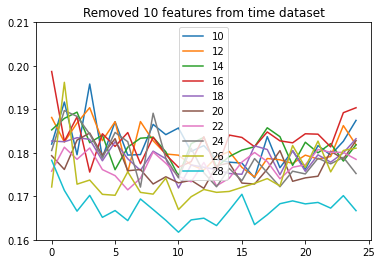

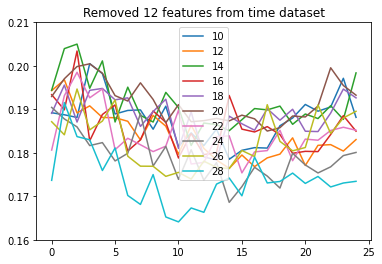

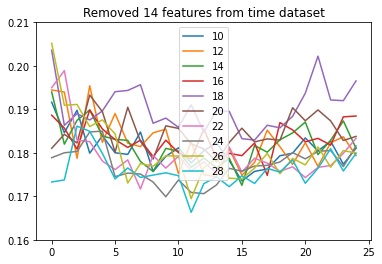

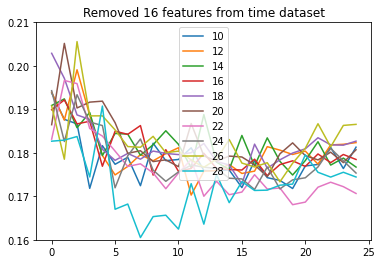

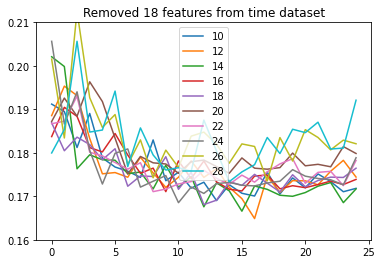

In [169]:
# modelList[-1][-1].append([])
# print(modelList)
val_loss = np.array([ [ [ z.history['val_loss'] for z in y ] for y in x ] for x in historyList ] )
val_loss_avg = np.mean(val_loss, axis = 2)

# fig = plt.figure()
# fig.set_size_inches(20,8) 

numRemove_time = [10+x*2 for x in range(5)]
numRemove_static = [10+x*2 for x in range(10)]

for i_time in range(5):
    plt.figure(i_time)
    for i_static in range(10):
        plt.plot(val_loss_avg[i_static, i_time, :])
    plt.ylim(0.16, 0.21)
    plt.legend(numRemove_static)
    plt.title('Removed %d features from time dataset' % (numRemove_time[i_time]))
    plt.show

In [170]:
my_data = {'num removed features_time': numRemove_time,
           'num removed features_static': numRemove_static,
           'validation loss': val_loss_avg}
output = open('valLoss_after removing features.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

## Retrain the model with selected features - 2nd

In [188]:
sortedFeatures_static = [columns_aftPCA[i] for i in idx_static]
sortedFeatures_time = [columns_time[i] for i in idx_time]

inputSize = 7
normalizeTarget = False

quantile = 0.5
num_epoch = 25

NUM_CELLS = 128
NUM_DAYS_OUT = 14

num_repeat = 2
modelList = []
historyList2 = []

numRemove_time_list = [10]
numRemove_static_list = [27, 28, 29]

for numRemove_static in numRemove_static_list:
    modelList.append([])
    historyList2.append([])
    
    columns_static_selected = sortedFeatures_static[numRemove_static:]

    # choose features from static data
    dataList_static_PCA, fips_noData_static_PCA, fips_final_static_PCA = concatDF_static(
        df_berk_withPCA, columns_static_selected, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])
    
    # normzliation
    data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)

    # for static dataset
    trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

    for numRemove_time in numRemove_time_list:
        modelList[-1].append([])
        historyList2[-1].append([])
        
        columns_time_selected = sortedFeatures_time[numRemove_time:]

        # choose features from time-series data
        columns_mortality = ['cases', 'deaths']
        columns_mobility = ['m50', 'm50_index']
        columns_season = ['seasonality']
        columns_testResult = ['positive', 'negative', 'pending', 'hospitalizedCurrently',
               'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
               'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 
               'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease',
               'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
               'totalTestResultsIncrease'] 
        columns_mortality_tmp = [ x for x in columns_mortality if x in columns_time_selected]
        columns_mobility_tmp = [ x for x in columns_mobility if x in columns_time_selected]
        columns_season_tmp = [ x for x in columns_season if x in columns_time_selected]
        columns_testResult_tmp = [ x for x in columns_testResult if x in columns_time_selected]
        columns_time_selected_reorder = columns_mortality_tmp+columns_mobility_tmp+columns_season_tmp+columns_testResult_tmp
        dataList_time, fips_noData_time, fips_final_time = concatDF_timeseries(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, df_testResult_eachCounty,
                                                                 columns_mortality_tmp, columns_mobility_tmp, columns_season_tmp, columns_testResult_tmp,
                                                                 fipsList, df_fips2state, df_berk2, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 0)

        # normalization
        data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

        # for timeseries dataset
        trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time_selected_reorder)

        # unnormalize the targets
        if not normalizeTarget:
            trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time_selected_reorder, 'deaths')

            
        # train the model
        for rep in range(num_repeat):
            model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
            model.call([trainingData_time, trainingData_static])
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
            history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
                      validation_data=([testingData_time, testingData_static], testingAns_time),
                      epochs=num_epoch, shuffle=True, batch_size=64)
            modelList[-1][-1].append(model)
            historyList2[-1][-1].append(history)
            

fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not found
fips  02261 not found
fips  02290 not found
fips  08014 not found
fips  46102 not found
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 11s 78us/sample - loss: 0.1274 - val_loss: 0.1665
Epoch 2/25
136770/136770 [==============================] - 10s 73us/sample - loss: 0.1130 - val_loss: 0.1831
Epoch 3/25
136770/136770 [==============================] - 10s 75us/sample - loss: 0.1081 - val_loss: 0.1697
Epoch 4/25
136770/136770 [==============================] - 10s 73us/sample - loss: 0.1048 - val_loss: 0.1661
Epoch 5/25
136770/136770 [==============================] - 10s 73us/sample - loss: 0.1023 - val_loss: 0.1627
Epoch 6/25
136770/136770 [

Epoch 17/25
136770/136770 [==============================] - 11s 77us/sample - loss: 0.0936 - val_loss: 0.1623
Epoch 18/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0931 - val_loss: 0.1718
Epoch 19/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0927 - val_loss: 0.1608
Epoch 20/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0921 - val_loss: 0.1576
Epoch 21/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0916 - val_loss: 0.1668
Epoch 22/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0913 - val_loss: 0.1658
Epoch 23/25
136770/136770 [==============================] - 10s 77us/sample - loss: 0.0912 - val_loss: 0.1603
Epoch 24/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0905 - val_loss: 0.1634
Epoch 25/25
136770/136770 [==============================] - 10s 76us/sample - loss: 0.0902 - val_loss: 0.1622
T

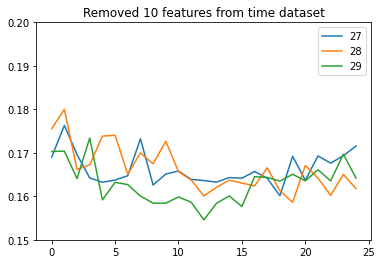

In [190]:
# modelList[-1][-1].append([])
# print(modelList)
val_loss2 = np.array([ [ [ z.history['val_loss'] for z in y ] for y in x ] for x in historyList2 ] )
val_loss_avg2 = np.mean(val_loss2, axis = 2)

# numRemove_time_list = [9, 10, 11]
# numRemove_static_list = [28, 30, 32, 34]

for i_time, _ in enumerate(numRemove_time_list):
    plt.figure(i_time)
    for i_static, _ in enumerate(numRemove_static_list):
        plt.plot(val_loss_avg2[i_static, i_time, :])
    plt.ylim(0.15, 0.20)
    plt.legend(numRemove_static_list)
    plt.title('Removed %d features from time dataset' % (numRemove_time_list[i_time]))
    plt.show

In [193]:
my_data = {'num removed features_time': numRemove_time_list,
           'num removed features_static': numRemove_static_list,
           'validation loss': val_loss_avg}
output = open('valLoss_after removing features_3.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

#load the data
import pprint
pkl_file = open('valLoss_after removing features_3.pkl', 'rb')
my_data = pickle.load(pkl_file)
pprint.pprint(my_data)
test = my_data['validation loss']
print(test)
pkl_file.close()

{'num removed features_static': [27, 28, 29],
 'num removed features_time': [10],
 'validation loss': array([[[0.18200269, 0.19167936, 0.17955769, ..., 0.17950387,
         0.18265716, 0.1874571 ],
        [0.18921896, 0.18875061, 0.1881371 , ..., 0.190544  ,
         0.1971377 , 0.18815542],
        [0.19164631, 0.18463967, 0.18978828, ..., 0.18265818,
         0.17739121, 0.18108073],
        [0.19375635, 0.1877061 , 0.18665617, ..., 0.18124949,
         0.17638582, 0.18130095],
        [0.19120168, 0.18949201, 0.18122458, ..., 0.1733893 ,
         0.17105339, 0.17183085]],

       [[0.18813225, 0.18247392, 0.18685126, ..., 0.17914874,
         0.18625655, 0.18182618],
        [0.19430451, 0.19680524, 0.18917822, ..., 0.18188451,
         0.18041085, 0.18304883],
        [0.19445246, 0.19397231, 0.17873941, ..., 0.18232374,
         0.18368356, 0.17936613],
        [0.19395539, 0.1875149 , 0.19909936, ..., 0.18181852,
         0.18196111, 0.18234685],
        [0.18855574, 0.19533868,

In [150]:
# train the model
quantile = 0.5
num_epoch = 17

NUM_CELLS = 128
NUM_DAYS_OUT = 14

num_repeat = 5
modelList = []
hisoryList = []

for rep in range(num_repeat):
    model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
    model.call([trainingData_time, trainingData_static])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
    history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
              validation_data=([testingData_time, testingData_static], testingAns_time),
              epochs=num_epoch, shuffle=True, batch_size=128)
    modelList.append(model)
    hisoryList.append(history)
    

Train on 136770 samples, validate on 2910 samples
Epoch 1/17
136770/136770 [==============================] - 9s 64us/sample - loss: 0.1321 - val_loss: 0.1901
Epoch 2/17
136770/136770 [==============================] - 8s 58us/sample - loss: 0.1131 - val_loss: 0.1951
Epoch 3/17
136770/136770 [==============================] - 8s 58us/sample - loss: 0.1064 - val_loss: 0.1923
Epoch 4/17
136770/136770 [==============================] - 8s 58us/sample - loss: 0.1028 - val_loss: 0.2018
Epoch 5/17
136770/136770 [==============================] - 8s 57us/sample - loss: 0.1004 - val_loss: 0.2020
Epoch 6/17
136770/136770 [==============================] - 8s 58us/sample - loss: 0.0988 - val_loss: 0.1878
Epoch 7/17
136770/136770 [==============================] - 8s 57us/sample - loss: 0.0974 - val_loss: 0.2028
Epoch 8/17
136770/136770 [==============================] - 8s 57us/sample - loss: 0.0963 - val_loss: 0.1871
Epoch 9/17
136770/136770 [==============================] - 8s 57us/sample - l

KeyboardInterrupt: 

In [141]:
#columns_time_selected
trainingAns_time

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [108]:
dataList_static_PCA[1].shape

(25,)

In [195]:
#columns_time_selected
len(sortedFeatures_static)

30

## retrain with additional features from 2nd PCA

In [273]:
df_berk_PCA_lowCorr = df_berk2.copy()

df_berk_PCA_highCorr = df_berk_PCA_lowCorr[columns_highCorr]
df_berk_PCA_lowCorr = df_berk_PCA_lowCorr[columns_lowCorr]

# run PCA - more features
df_berk_PCA_highCorr_np = StandardScaler().fit_transform(df_berk_PCA_highCorr)
pca_highCorr = PCA(.9999)
pc_highCorr = pca_highCorr.fit_transform(df_berk_PCA_highCorr_np)
print(pc_highCorr.shape)

pc_highCorr_chosen = pc_highCorr[:, 0]
pc_highCorr_chosen = np.concatenate( (pc_highCorr_chosen[:, None], pc_highCorr[:, 18:]), axis = 1)
print(pc_highCorr_chosen.shape)

(3113, 29)
(3113, 12)


In [274]:
# run PCA - with low correlation features
df_berk_PCA_lowCorr_np = StandardScaler().fit_transform(df_berk_PCA_lowCorr)

# handle nan
nan_idx = np.argwhere(np.isnan(df_berk_PCA_lowCorr_np))
for i in nan_idx:
    #df_berk_PCA_lowCorr[i[0], i[1]] = np.nanmean( df_berk_PCA_lowCorr[:, i[1]] )
    df_berk_PCA_lowCorr_np[i[0], i[1]] = 0 # put mean value in NaN values
    
pca_lowCorr = PCA(.9999)
pc_lowCorr = pca_lowCorr.fit_transform(df_berk_PCA_lowCorr_np)
print(pc_lowCorr.shape)

(3113, 11)


In [277]:
pc_highCorr_df = pd.DataFrame(pc_highCorr_chosen)
pc_highCorr_df.index = df_berk_withPCA2.index
temp = ['pc%d_highCorr' % (x) for x in range(18,29)]
temp = ['pc0_highCorr'] + temp
pc_highCorr_df.columns = temp

pc_lowCorr_df = pd.DataFrame(pc_lowCorr)
pc_lowCorr_df.index = df_berk_withPCA2.index
pc_lowCorr_df.columns = ['pc%d_lowCorr' % (x) for x in range(0, 11)]
pc_lowCorr_df.head()

,pc0_lowCorr,pc1_lowCorr,pc2_lowCorr,pc3_lowCorr,pc4_lowCorr,pc5_lowCorr,pc6_lowCorr,pc7_lowCorr,pc8_lowCorr,pc9_lowCorr,pc10_lowCorr
countyFIPS,,,,,,,,,,,
01001,-1.920765,-0.616825,-0.228855,-0.719160,1.044173,0.450038,-0.872305,0.248665,-0.646123,-0.298276,0.099379
01003,-0.197258,-0.564687,0.149720,-0.774612,0.971705,0.959344,-0.197459,0.202042,0.603163,-0.561623,0.038032
01005,-1.890473,-1.649408,-0.200010,1.240554,0.001178,0.639982,0.424963,-0.497122,-0.178309,-0.266453,-0.141388
01007,-1.919043,-1.371678,-0.959439,1.128664,0.499509,0.814550,-0.448829,0.134620,-1.000886,0.107855,0.064849
01009,-1.700856,-1.590385,-0.229938,-0.275677,0.445994,0.071080,0.168706,0.448139,-0.598607,0.021366,0.105875


In [283]:
df_berk_withPCA = pd.concat([pc_highCorr_df, pc_lowCorr_df], axis=1)
df_berk_withPCA.head()

columns_aftPCA = df_berk_withPCA.columns

In [292]:
dataList_static_PCA, fips_noData_static_PCA, fips_final_static_PCA = concatDF_static(
    df_berk_withPCA, columns_aftPCA, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])

# normalization
data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)
data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

# for static dataset
inputSize = 7
trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

# for timeseries dataset
# choose features from time-series data
columns_time_selected = sortedFeatures_time[10:]
columns_mortality_tmp = [ x for x in columns_mortality if x in columns_time_selected]
columns_mobility_tmp = [ x for x in columns_mobility if x in columns_time_selected]
columns_season_tmp = [ x for x in columns_season if x in columns_time_selected]
columns_testResult_tmp = [ x for x in columns_testResult if x in columns_time_selected]
columns_time_selected_reorder = columns_mortality_tmp+columns_mobility_tmp+columns_season_tmp+columns_testResult_tmp
dataList_time, fips_noData_time, fips_final_time = concatDF_timeseries(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, df_testResult_eachCounty,
                                                         columns_mortality_tmp, columns_mobility_tmp, columns_season_tmp, columns_testResult_tmp,
                                                         fipsList, df_fips2state, df_berk2, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 0)

# normalization
data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

# for timeseries dataset
trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time)

# unnormalize the targets
normalizeTarget = False

if not normalizeTarget:
    trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time, 'deaths')

fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not found
fips  02261 not found
fips  02290 not found
fips  08014 not found
fips  46102 not found


In [319]:
columns_time_selected_reorder

['cases',
 'deaths',
 'positive',
 'hospitalizedCurrently',
 'hospitalizedCumulative',
 'inIcuCurrently',
 'inIcuCumulative',
 'onVentilatorCurrently',
 'recovered',
 'hospitalized',
 'deathIncrease',
 'negativeIncrease',
 'positiveIncrease',
 'totalTestResultsIncrease']

In [300]:
# train the model
quantile = 0.5
num_epoch = 20

NUM_CELLS = 128
NUM_DAYS_OUT = 14

num_repeat = 5
modelList_withPCA = []
hisoryList_withPCA = []

for rep in range(num_repeat):
    model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
    model.call([trainingData_time, trainingData_static])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
    history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
              validation_data=([testingData_time, testingData_static], testingAns_time),
              epochs=num_epoch, shuffle=True, batch_size=64)
    modelList_withPCA.append(model)
    hisoryList_withPCA.append(history)
    

Train on 136770 samples, validate on 2910 samples
Epoch 1/20
136770/136770 [==============================] - 13s 92us/sample - loss: 0.1248 - val_loss: 0.1777
Epoch 2/20
136770/136770 [==============================] - 12s 89us/sample - loss: 0.1081 - val_loss: 0.1812
Epoch 3/20
136770/136770 [==============================] - 12s 88us/sample - loss: 0.1027 - val_loss: 0.1821
Epoch 4/20
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0995 - val_loss: 0.1767
Epoch 5/20
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0976 - val_loss: 0.1774
Epoch 6/20
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0968 - val_loss: 0.1761
Epoch 7/20
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0956 - val_loss: 0.1703
Epoch 8/20
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0949 - val_loss: 0.1832
Epoch 9/20
136770/136770 [==============================] - 12s 85us/s

136770/136770 [==============================] - 12s 87us/sample - loss: 0.0921 - val_loss: 0.1764
Epoch 14/20
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0917 - val_loss: 0.1663
Epoch 15/20
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0913 - val_loss: 0.1723
Epoch 16/20
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0909 - val_loss: 0.1790
Epoch 17/20
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0903 - val_loss: 0.1670
Epoch 18/20
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0898 - val_loss: 0.1662
Epoch 19/20
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0895 - val_loss: 0.1679
Epoch 20/20
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0891 - val_loss: 0.1704
Train on 136770 samples, validate on 2910 samples
Epoch 1/20
136770/136770 [==============================] - 12s 91us/sampl

In [301]:
# save trained models and histories
import pickle
for i in range(5):
    name = "models_0.5quantile, 5models, 17maxEpoch_%d_withPCAonStatic2" % (i)
    modelList_withPCA[i].save_weights(name, save_format="tf")

# output = open('models_50%quantile, 10models, 15maxEpoch.pkl', 'wb')
# pickle.dump(modelList_featureTest, output)
# output.close()


In [310]:
# get validation error after shuffling each colunm - demographic data
print(testingData_static.shape)
num_repeat = 10
featureTest_valLoss_static = []
for i in range(testingData_static.shape[1]):
    featureTest_valLoss_static.append([])
    for rep in range(num_repeat):
        testingData_static_shuffle = testingData_static.copy()
        testingData_static_shuffle[:, i] = np.random.permutation(testingData_static_shuffle[:, i])
        prediction_temp = [x.predict([testingData_time, testingData_static_shuffle]) for x in modelList_withPCA]
        featureTest_valLoss_static[-1].append( [np.mean(abs(x-testingAns_time))/2 for x in prediction_temp] )
    print(i, ". ", columns_aftPCA[i], ": validation loss = ", np.mean(featureTest_valLoss_static[-1]))
    
# get validation error after shuffling each colunm - time-series data
print(testingData_time.shape)
num_repeat = 100
featureTest_valLoss_time = []
for i in range(testingData_time.shape[2]):
    featureTest_valLoss_time.append([])
    for rep in range(num_repeat):
        testingData_time_shuffle = testingData_time.copy()
        testingData_time_shuffle[:, :, i] = np.random.permutation(testingData_time_shuffle[:, :, i])
        prediction_temp = [x.predict([testingData_time_shuffle, testingData_static]) for x in modelList_withPCA]
        featureTest_valLoss_time[-1].append( [np.mean(abs(x-testingAns_time))/2 for x in prediction_temp] )
    print(i, ". ", columns_time_selected_reorder[i], ": validation loss = ", np.mean(featureTest_valLoss_time[-1]))    

(2910, 23)
0 .  pc0_highCorr : validation loss =  0.20498590052127838
1 .  pc18_highCorr : validation loss =  0.17648444712162017
2 .  pc19_highCorr : validation loss =  0.17624812990427016
3 .  pc20_highCorr : validation loss =  0.17627773493528365
4 .  pc21_highCorr : validation loss =  0.17875211030244828
5 .  pc22_highCorr : validation loss =  0.1779854953289032
6 .  pc23_highCorr : validation loss =  0.176802536547184
7 .  pc24_highCorr : validation loss =  0.17781702131032945
8 .  pc25_highCorr : validation loss =  0.17770019948482513
9 .  pc26_highCorr : validation loss =  0.1774197807908058
10 .  pc27_highCorr : validation loss =  0.1774957937002182
11 .  pc28_highCorr : validation loss =  0.17820541620254515
12 .  pc0_lowCorr : validation loss =  0.17753308653831482
13 .  pc1_lowCorr : validation loss =  0.17646078944206237
14 .  pc2_lowCorr : validation loss =  0.17316751480102538
15 .  pc3_lowCorr : validation loss =  0.17732949286699295
16 .  pc4_lowCorr : validation loss =

<function matplotlib.pyplot.show(*args, **kw)>

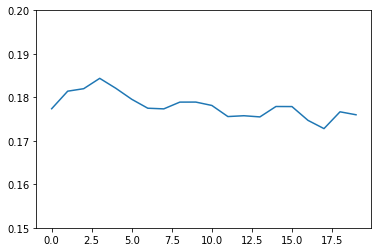

In [323]:
# val_loss_mae = np.array([ y.history['val_loss'] for y in hisoryList_withPCA])
# val_loss_mae_std = np.std(val_loss_mae, axis = 0)
# val_loss_mae_avg = np.mean(val_loss_mae, axis = 0)
val_loss_mae_avg.shape

plt.figure(1)
plt.plot(val_loss_mae_avg)
plt.ylim(0.15, 0.20)
plt.show

In [311]:
# save the data - demographic data
import pickle
featureTest_valLoss_static_np = np.array(featureTest_valLoss_static)
my_data = {'feature name': columns_aftPCA,
           'validation loss': featureTest_valLoss_static_np}
output = open('featureImportanceAnalysis_static_aftPCA_v2.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

# load the data
# import pprint
# pkl_file = open('featureImportanceAnalysis_static.pkl', 'rb')
# my_data = pickle.load(pkl_file)
# # pprint.pprint(my_data)
# pkl_file.close()


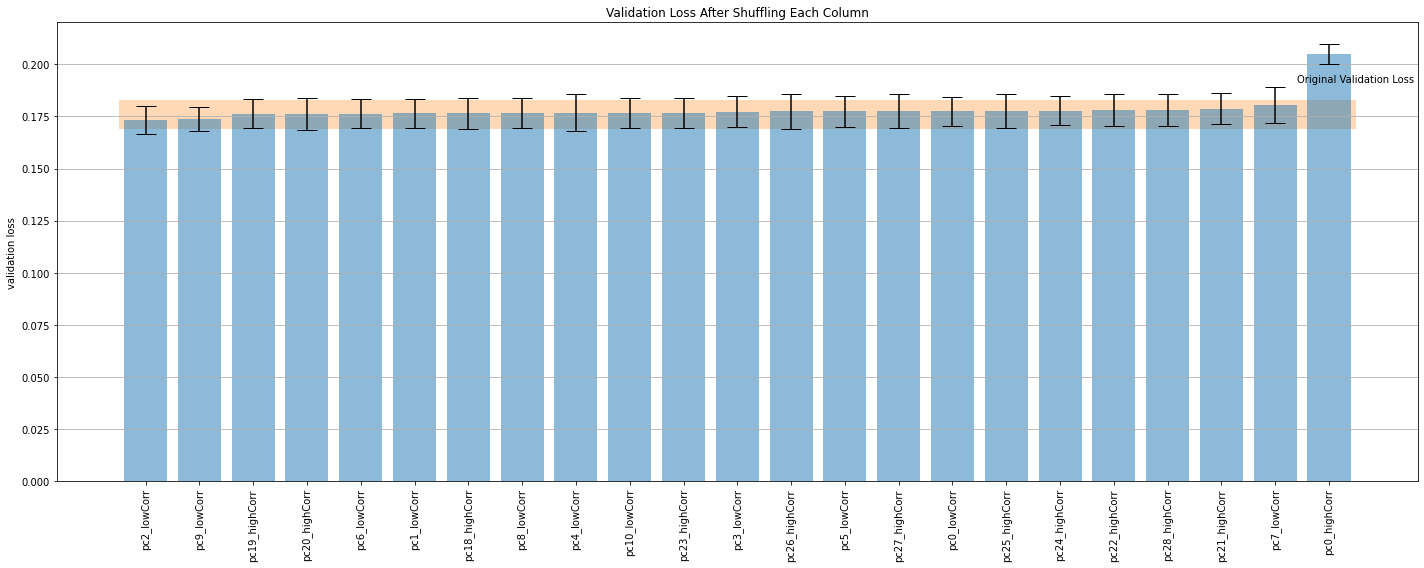

In [313]:
# plot the validation loss - demographic data
featureTest_valLoss_static_mean = [ np.mean(featureTest_valLoss_static_np[x,:,:]) for x in range(len(columns_aftPCA)) ]
featureTest_valLoss_static_std = [ np.std(featureTest_valLoss_static_np[x,:,:]) for x in range(len(columns_aftPCA)) ]

x_pos = np.arange(len(columns_aftPCA))

idx_static = np.array(np.argsort(featureTest_valLoss_static_mean))

fig, ax = plt.subplots()
fig.set_size_inches(20,8) 
ax.bar(x_pos, [featureTest_valLoss_static_mean[i] for i in idx_static],
       yerr=[featureTest_valLoss_static_std[i] for i in idx_static],
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('validation loss')
ax.set_xticks(x_pos)
ax.set_xticklabels([columns_aftPCA[i] for i in idx_static], rotation='vertical')
ax.set_title('Validation Loss After Shuffling Each Column')
ax.yaxis.grid(True)

# add line for validation loss of original model
yerr_pos = val_loss_mae_avg[-1]+val_loss_mae_std[-1]
yerr_neg = val_loss_mae_avg[-1]-val_loss_mae_std[-1]
ax.fill_between([-0.5, len(x_pos)-0.5], [yerr_pos, yerr_pos], [yerr_neg, yerr_neg], alpha = 0.3)
ax.text(len(x_pos)-0.5, yerr_pos+0.01, 'Original Validation Loss', horizontalalignment='center', verticalalignment='center')

# Save the figure and show
plt.tight_layout()
plt.savefig('featureTest_valLoss_static_aftPCA_v2.png')
plt.show()

In [316]:
# save the data - time-series data
import pickle
featureTest_valLoss_time_np = np.array(featureTest_valLoss_time)
my_data = {'feature name': columns_time_selected_reorder,
           'validation loss': featureTest_valLoss_time_np}
output = open('featureImportanceAnalysis_time_withStaticAftPCA_v2.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

# load the data
# import pprint
# pkl_file = open('featureImportanceAnalysis_static.pkl', 'rb')
# my_data = pickle.load(pkl_file)
# # pprint.pprint(my_data)
# pkl_file.close()

(14, 100, 5)


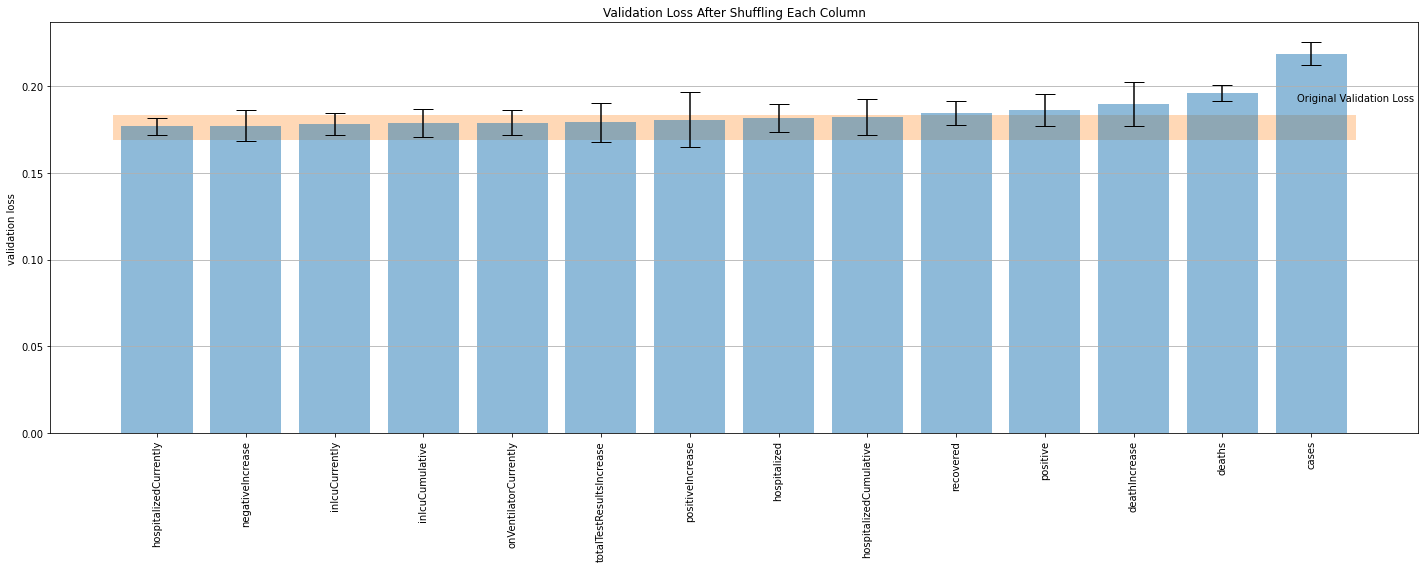

In [320]:
# plot the validation loss - time-series data
print(featureTest_valLoss_time_np.shape)
featureTest_valLoss_time_mean = [ np.mean(featureTest_valLoss_time_np[x,:,:]) for x in range(len(columns_time_selected_reorder)) ]
featureTest_valLoss_time_std = [ np.std(featureTest_valLoss_time_np[x,:,:]) for x in range(len(columns_time_selected_reorder)) ]

x_pos = np.arange(len(columns_time_selected_reorder))

idx_time = np.array(np.argsort(featureTest_valLoss_time_mean))

fig, ax = plt.subplots()
fig.set_size_inches(20,8) 
ax.bar(x_pos, [featureTest_valLoss_time_mean[i] for i in idx_time],
       yerr= [featureTest_valLoss_time_std[i] for i in idx_time],
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('validation loss')
ax.set_xticks(x_pos)
ax.set_xticklabels([columns_time_selected_reorder[i] for i in idx_time], rotation='vertical')
ax.set_title('Validation Loss After Shuffling Each Column')
ax.yaxis.grid(True)

# add line for validation loss of original model
yerr_pos = val_loss_mae_avg[-1]+val_loss_mae_std[-1]
yerr_neg = val_loss_mae_avg[-1]-val_loss_mae_std[-1]
ax.fill_between([-0.5, len(x_pos)-0.5], [yerr_pos, yerr_pos], [yerr_neg, yerr_neg], alpha = 0.3)
ax.text(len(x_pos)-0.5, yerr_pos+0.01, 'Original Validation Loss', horizontalalignment='center', verticalalignment='center')

# Save the figure and show
plt.tight_layout()
plt.savefig('featureTest_valLoss_time_aftPCA_v2.png')
plt.show()

## Retrain the model after removing features - 2nd

In [342]:
print(len(columns_aftPCA))
print(len(sortedFeatures_time))
print(np.arange(1,5))
test = ['cases',
 'deaths',
 'positive',
 'hospitalizedCurrently',
 'hospitalizedCumulative',
 'inIcuCurrently',
 'inIcuCumulative',
 'onVentilatorCurrently',
 'recovered',
 'hospitalized',
 'deathIncrease',
 'negativeIncrease',
 'positiveIncrease',
 'totalTestResultsIncrease']
sortedFeatures_time = [test[i] for i in idx_time]
print(sortedFeatures_static[22:])

23
14
[1 2 3 4]
['pc0_highCorr']
numRemove_static: 3
numRemove_time: 15


In [358]:
sortedFeatures_static = [columns_aftPCA[i] for i in idx_static]

inputSize = 7
normalizeTarget = False

quantile = 0.5
num_epoch = 25

NUM_CELLS = 128
NUM_DAYS_OUT = 14

num_repeat = 2
modelList = []
historyList2 = []

numRemove_time_list = np.arange(0,5)*3
numRemove_static_list = [4, 8, 12, 16, 18, 19, 20, 21, 22]

for numRemove_static in numRemove_static_list:
    modelList.append([])
    historyList2.append([])
    
    columns_static_selected = sortedFeatures_static[numRemove_static:]
    print(columns_static_selected)

    # choose features from static data
    dataList_static_PCA, fips_noData_static_PCA, fips_final_static_PCA = concatDF_static(
        df_berk_withPCA, columns_static_selected, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])
    
    # normzliation
    data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)

    # for static dataset
    trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

    for numRemove_time in numRemove_time_list:
        print('numRemove_static: %d' %(numRemove_static))
        print('numRemove_time: %d' %(numRemove_time))
        
        modelList[-1].append([])
        historyList2[-1].append([])
        
        columns_time_selected = sortedFeatures_time[numRemove_time:]

        # choose features from time-series data
        columns_mortality = ['cases', 'deaths']
        columns_mobility = ['m50', 'm50_index']
        columns_season = ['seasonality']
        columns_testResult = ['positive', 'negative', 'pending', 'hospitalizedCurrently',
               'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
               'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 
               'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease',
               'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
               'totalTestResultsIncrease'] 
        columns_mortality_tmp = [ x for x in columns_mortality if x in columns_time_selected]
        columns_mobility_tmp = [ x for x in columns_mobility if x in columns_time_selected]
        columns_season_tmp = [ x for x in columns_season if x in columns_time_selected]
        columns_testResult_tmp = [ x for x in columns_testResult if x in columns_time_selected]
        columns_time_selected_reorder = columns_mortality_tmp+columns_mobility_tmp+columns_season_tmp+columns_testResult_tmp
        dataList_time, fips_noData_time, fips_final_time = concatDF_timeseries(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, df_testResult_eachCounty,
                                                                 columns_mortality_tmp, columns_mobility_tmp, columns_season_tmp, columns_testResult_tmp,
                                                                 fipsList, df_fips2state, df_berk2, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 0)
        print(columns_time_selected_reorder)

        # normalization
        data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

        # for timeseries dataset
        trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time_selected_reorder)

        # unnormalize the targets
        if not normalizeTarget:
            trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time_selected_reorder, 'deaths')

            
        # train the model
        for rep in range(num_repeat):
            model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
            model.call([trainingData_time, trainingData_static])
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
            history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
                      validation_data=([testingData_time, testingData_static], testingAns_time),
                      epochs=num_epoch, shuffle=True, batch_size=64)
            modelList[-1][-1].append(model)
            historyList2[-1][-1].append(history)
            

['pc6_lowCorr', 'pc1_lowCorr', 'pc18_highCorr', 'pc8_lowCorr', 'pc4_lowCorr', 'pc10_lowCorr', 'pc23_highCorr', 'pc3_lowCorr', 'pc26_highCorr', 'pc5_lowCorr', 'pc27_highCorr', 'pc0_lowCorr', 'pc25_highCorr', 'pc24_highCorr', 'pc22_highCorr', 'pc28_highCorr', 'pc21_highCorr', 'pc7_lowCorr', 'pc0_highCorr']
fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not found
fips  02261 not found
fips  02290 not found
fips  08014 not found
fips  46102 not found
numRemove_static: 4
numRemove_time: 0
['cases', 'deaths', 'positive', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'recovered', 'hospitalized', 'deathIncrease', 'negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease']
Train on 136770 samples

Epoch 13/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0925 - val_loss: 0.1760
Epoch 14/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0919 - val_loss: 0.1734
Epoch 15/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0917 - val_loss: 0.1734
Epoch 16/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0912 - val_loss: 0.1839
Epoch 17/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0907 - val_loss: 0.1759
Epoch 18/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0903 - val_loss: 0.1751
Epoch 19/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0898 - val_loss: 0.1779
Epoch 20/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0894 - val_loss: 0.1895
Epoch 21/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0889 - val_loss: 0.1883
E

136770/136770 [==============================] - 12s 88us/sample - loss: 0.0945 - val_loss: 0.1691
Epoch 10/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0941 - val_loss: 0.1693
Epoch 11/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0936 - val_loss: 0.1738
Epoch 12/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0932 - val_loss: 0.1693
Epoch 13/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0927 - val_loss: 0.1699
Epoch 14/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0923 - val_loss: 0.1728
Epoch 15/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0920 - val_loss: 0.1744
Epoch 16/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0917 - val_loss: 0.1732
Epoch 17/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0912 - val_loss: 0.1736
Epoch 18/25
1

136770/136770 [==============================] - 12s 86us/sample - loss: 0.0992 - val_loss: 0.1637
Epoch 6/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0981 - val_loss: 0.1658
Epoch 7/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0971 - val_loss: 0.1685
Epoch 8/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0961 - val_loss: 0.1706
Epoch 9/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0955 - val_loss: 0.1711
Epoch 10/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0949 - val_loss: 0.1662
Epoch 11/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0943 - val_loss: 0.1745
Epoch 12/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0940 - val_loss: 0.1737
Epoch 13/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0935 - val_loss: 0.1710
Epoch 14/25
13677

Epoch 20/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0894 - val_loss: 0.1760
Epoch 21/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0891 - val_loss: 0.1724
Epoch 22/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0887 - val_loss: 0.1727
Epoch 23/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0885 - val_loss: 0.1739
Epoch 24/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0881 - val_loss: 0.1741
Epoch 25/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0878 - val_loss: 0.1797
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.1262 - val_loss: 0.1832
Epoch 2/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.1094 - val_loss: 0.1820
Epoch 3/25
136770/136770 [==============================] - 12s 

136770/136770 [==============================] - 12s 86us/sample - loss: 0.0911 - val_loss: 0.1679
Epoch 16/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0907 - val_loss: 0.1710
Epoch 17/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0902 - val_loss: 0.1738
Epoch 18/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0898 - val_loss: 0.1689
Epoch 19/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0893 - val_loss: 0.1688
Epoch 20/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0890 - val_loss: 0.1691
Epoch 21/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0886 - val_loss: 0.1725
Epoch 22/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0882 - val_loss: 0.1733
Epoch 23/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0879 - val_loss: 0.1734
Epoch 24/25
1

136770/136770 [==============================] - 12s 84us/sample - loss: 0.0946 - val_loss: 0.1677
Epoch 11/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0941 - val_loss: 0.1641
Epoch 12/25
136770/136770 [==============================] - 12s 84us/sample - loss: 0.0937 - val_loss: 0.1667
Epoch 13/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0932 - val_loss: 0.1655
Epoch 14/25
136770/136770 [==============================] - 12s 84us/sample - loss: 0.0927 - val_loss: 0.1672
Epoch 15/25
136770/136770 [==============================] - 12s 84us/sample - loss: 0.0924 - val_loss: 0.1668
Epoch 16/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0920 - val_loss: 0.1668
Epoch 17/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0915 - val_loss: 0.1652
Epoch 18/25
136770/136770 [==============================] - 12s 85us/sample - loss: 0.0910 - val_loss: 0.1687
Epoch 19/25
1

136770/136770 [==============================] - 11s 84us/sample - loss: 0.0970 - val_loss: 0.1730
Epoch 8/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0961 - val_loss: 0.1631
Epoch 9/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0953 - val_loss: 0.1607
Epoch 10/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0948 - val_loss: 0.1681
Epoch 11/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0942 - val_loss: 0.1655
Epoch 12/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0939 - val_loss: 0.1671
Epoch 13/25
136770/136770 [==============================] - 11s 83us/sample - loss: 0.0933 - val_loss: 0.1630
Epoch 14/25
136770/136770 [==============================] - 12s 86us/sample - loss: 0.0930 - val_loss: 0.1670
Epoch 15/25
136770/136770 [==============================] - 12s 87us/sample - loss: 0.0926 - val_loss: 0.1637
Epoch 16/25
136

136770/136770 [==============================] - 12s 88us/sample - loss: 0.0889 - val_loss: 0.1757
Epoch 23/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0887 - val_loss: 0.1752
Epoch 24/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0883 - val_loss: 0.1708
Epoch 25/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0880 - val_loss: 0.1740
numRemove_static: 12
numRemove_time: 3
['cases', 'deaths', 'positive', 'hospitalizedCumulative', 'inIcuCumulative', 'onVentilatorCurrently', 'recovered', 'hospitalized', 'deathIncrease', 'positiveIncrease', 'totalTestResultsIncrease']
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.1263 - val_loss: 0.1789
Epoch 2/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.1097 - val_loss: 0.1790
Epoch 3/25
136770/136770 [==============================] - 12s

136770/136770 [==============================] - 12s 88us/sample - loss: 0.0912 - val_loss: 0.1700
Epoch 17/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0908 - val_loss: 0.1680
Epoch 18/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0904 - val_loss: 0.1713
Epoch 19/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0899 - val_loss: 0.1660
Epoch 20/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0897 - val_loss: 0.1674
Epoch 21/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0892 - val_loss: 0.1667
Epoch 22/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0889 - val_loss: 0.1657
Epoch 23/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0886 - val_loss: 0.1676
Epoch 24/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0884 - val_loss: 0.1655
Epoch 25/25
1

Epoch 13/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0936 - val_loss: 0.1705
Epoch 14/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0931 - val_loss: 0.1695
Epoch 15/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0927 - val_loss: 0.1679
Epoch 16/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0921 - val_loss: 0.1657
Epoch 17/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0918 - val_loss: 0.1720
Epoch 18/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0913 - val_loss: 0.1664
Epoch 19/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0908 - val_loss: 0.1670
Epoch 20/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0904 - val_loss: 0.1661
Epoch 21/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0901 - val_loss: 0.1644
E

Epoch 3/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.1055 - val_loss: 0.1821
Epoch 4/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.1022 - val_loss: 0.1769
Epoch 5/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0998 - val_loss: 0.1759
Epoch 6/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0981 - val_loss: 0.1737
Epoch 7/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0972 - val_loss: 0.1762
Epoch 8/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0963 - val_loss: 0.1720
Epoch 9/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0956 - val_loss: 0.1801
Epoch 10/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0949 - val_loss: 0.1781
Epoch 11/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0943 - val_loss: 0.1739
Epoch 12

136770/136770 [==============================] - 12s 90us/sample - loss: 0.0888 - val_loss: 0.1722
Epoch 25/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0884 - val_loss: 0.1746
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.1271 - val_loss: 0.1814
Epoch 2/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.1107 - val_loss: 0.1755
Epoch 3/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.1053 - val_loss: 0.1858
Epoch 4/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.1019 - val_loss: 0.1898
Epoch 5/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0995 - val_loss: 0.1746
Epoch 6/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0982 - val_loss: 0.1643
Epoch 7/25
136770/136770 [==============================] - 12s 90us/sample - lo

136770/136770 [==============================] - 12s 91us/sample - loss: 0.0901 - val_loss: 0.1638
Epoch 21/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0897 - val_loss: 0.1705
Epoch 22/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0894 - val_loss: 0.1674
Epoch 23/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0889 - val_loss: 0.1663
Epoch 24/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0886 - val_loss: 0.1688
Epoch 25/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0882 - val_loss: 0.1639
numRemove_static: 16
numRemove_time: 9
['cases', 'deaths', 'positive', 'recovered', 'deathIncrease']
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.1266 - val_loss: 0.1728
Epoch 2/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0

136770/136770 [==============================] - 12s 89us/sample - loss: 0.0928 - val_loss: 0.1674
Epoch 17/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0924 - val_loss: 0.1720
Epoch 18/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0921 - val_loss: 0.1686
Epoch 19/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0914 - val_loss: 0.1663
Epoch 20/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0911 - val_loss: 0.1695
Epoch 21/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0908 - val_loss: 0.1718
Epoch 22/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0902 - val_loss: 0.1666
Epoch 23/25
136770/136770 [==============================] - 12s 88us/sample - loss: 0.0900 - val_loss: 0.1657
Epoch 24/25
136770/136770 [==============================] - 12s 89us/sample - loss: 0.0896 - val_loss: 0.1714
Epoch 25/25
1

Epoch 7/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0981 - val_loss: 0.1728
Epoch 8/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0973 - val_loss: 0.1764
Epoch 9/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.0964 - val_loss: 0.1788
Epoch 10/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.0956 - val_loss: 0.1646
Epoch 11/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0949 - val_loss: 0.1652
Epoch 12/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0943 - val_loss: 0.1656
Epoch 13/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0937 - val_loss: 0.1684
Epoch 14/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0929 - val_loss: 0.1632
Epoch 15/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0923 - val_loss: 0.1622
Epoc

136770/136770 [==============================] - 13s 95us/sample - loss: 0.1268 - val_loss: 0.1704
Epoch 2/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1125 - val_loss: 0.1728
Epoch 3/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.1074 - val_loss: 0.1589
Epoch 4/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1044 - val_loss: 0.1692
Epoch 5/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1020 - val_loss: 0.1650
Epoch 6/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1005 - val_loss: 0.1699
Epoch 7/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0992 - val_loss: 0.1606
Epoch 8/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0983 - val_loss: 0.1634
Epoch 9/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0972 - val_loss: 0.1667
Epoch 10/25
136770/13

136770/136770 [==============================] - 13s 92us/sample - loss: 0.0899 - val_loss: 0.1799
Epoch 24/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0895 - val_loss: 0.1787
Epoch 25/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0892 - val_loss: 0.1840
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.1267 - val_loss: 0.1849
Epoch 2/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.1136 - val_loss: 0.1890
Epoch 3/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1085 - val_loss: 0.1997
Epoch 4/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1051 - val_loss: 0.1887
Epoch 5/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1028 - val_loss: 0.1882
Epoch 6/25
136770/136770 [==============================] - 12s 91us/sample - l

136770/136770 [==============================] - 12s 90us/sample - loss: 0.0921 - val_loss: 0.1890
Epoch 21/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0917 - val_loss: 0.1820
Epoch 22/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0914 - val_loss: 0.1798
Epoch 23/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0909 - val_loss: 0.1818
Epoch 24/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.0906 - val_loss: 0.1837
Epoch 25/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0903 - val_loss: 0.1917
['pc28_highCorr', 'pc21_highCorr', 'pc7_lowCorr', 'pc0_highCorr']
fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not 

136770/136770 [==============================] - 13s 94us/sample - loss: 0.0977 - val_loss: 0.1652
Epoch 10/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0968 - val_loss: 0.1602
Epoch 11/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0959 - val_loss: 0.1606
Epoch 12/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0952 - val_loss: 0.1653
Epoch 13/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0944 - val_loss: 0.1640
Epoch 14/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0938 - val_loss: 0.1634
Epoch 15/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.0933 - val_loss: 0.1646
Epoch 16/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0927 - val_loss: 0.1630
Epoch 17/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0920 - val_loss: 0.1599
Epoch 18/25
1

136770/136770 [==============================] - 13s 92us/sample - loss: 0.1036 - val_loss: 0.1611
Epoch 6/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.1019 - val_loss: 0.1724
Epoch 7/25
136770/136770 [==============================] - 13s 92us/sample - loss: 0.1004 - val_loss: 0.1706
Epoch 8/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0990 - val_loss: 0.1691
Epoch 9/25
136770/136770 [==============================] - 14s 99us/sample - loss: 0.0979 - val_loss: 0.1735
Epoch 10/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0967 - val_loss: 0.1629
Epoch 11/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0958 - val_loss: 0.1705
Epoch 12/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0949 - val_loss: 0.1643
Epoch 13/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0942 - val_loss: 0.1658
Epoch 14/25
13677

136770/136770 [==============================] - 13s 96us/sample - loss: 0.1262 - val_loss: 0.2042
Epoch 2/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1146 - val_loss: 0.2002
Epoch 3/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.1108 - val_loss: 0.2055
Epoch 4/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1076 - val_loss: 0.1780
Epoch 5/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.1052 - val_loss: 0.1941
Epoch 6/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.1031 - val_loss: 0.1793
Epoch 7/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1015 - val_loss: 0.1761
Epoch 8/25
136770/136770 [==============================] - 12s 91us/sample - loss: 0.1002 - val_loss: 0.1826
Epoch 9/25
136770/136770 [==============================] - 12s 90us/sample - loss: 0.0992 - val_loss: 0.1897
Epoch 10/25
136770/13

136770/136770 [==============================] - 13s 93us/sample - loss: 0.0926 - val_loss: 0.1696
Epoch 18/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0919 - val_loss: 0.1683
Epoch 19/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0915 - val_loss: 0.1663
Epoch 20/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0911 - val_loss: 0.1733
Epoch 21/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.0907 - val_loss: 0.1701
Epoch 22/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0902 - val_loss: 0.1692
Epoch 23/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.0900 - val_loss: 0.1683
Epoch 24/25
136770/136770 [==============================] - 13s 93us/sample - loss: 0.0895 - val_loss: 0.1810
Epoch 25/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.0892 - val_loss: 0.1720
Train on 1367

136770/136770 [==============================] - 13s 97us/sample - loss: 0.0966 - val_loss: 0.1740
Epoch 13/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0959 - val_loss: 0.1725
Epoch 14/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0952 - val_loss: 0.1702
Epoch 15/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0944 - val_loss: 0.1669
Epoch 16/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0940 - val_loss: 0.1686
Epoch 17/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0935 - val_loss: 0.1653
Epoch 18/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0929 - val_loss: 0.1680
Epoch 19/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0924 - val_loss: 0.1739
Epoch 20/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0918 - val_loss: 0.1742
Epoch 21/25
1

136770/136770 [==============================] - 13s 98us/sample - loss: 0.1030 - val_loss: 0.1670
Epoch 8/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1018 - val_loss: 0.1612
Epoch 9/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1006 - val_loss: 0.1657
Epoch 10/25
136770/136770 [==============================] - 14s 103us/sample - loss: 0.0994 - val_loss: 0.1603
Epoch 11/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0987 - val_loss: 0.1635
Epoch 12/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0976 - val_loss: 0.1703
Epoch 13/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0968 - val_loss: 0.1659
Epoch 14/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0963 - val_loss: 0.1629
Epoch 15/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0955 - val_loss: 0.1603
Epoch 16/25
13

136770/136770 [==============================] - 13s 95us/sample - loss: 0.1105 - val_loss: 0.1773
Epoch 5/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.1085 - val_loss: 0.1907
Epoch 6/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.1069 - val_loss: 0.2066
Epoch 7/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.1052 - val_loss: 0.1842
Epoch 8/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.1036 - val_loss: 0.1814
Epoch 9/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.1025 - val_loss: 0.1717
Epoch 10/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.1014 - val_loss: 0.1785
Epoch 11/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.1001 - val_loss: 0.1772
Epoch 12/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.0994 - val_loss: 0.1893
Epoch 13/25
136770

Epoch 21/25
136770/136770 [==============================] - 14s 101us/sample - loss: 0.0918 - val_loss: 0.1755
Epoch 22/25
136770/136770 [==============================] - 14s 99us/sample - loss: 0.0912 - val_loss: 0.1733
Epoch 23/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0909 - val_loss: 0.1791
Epoch 24/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0905 - val_loss: 0.1760
Epoch 25/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0902 - val_loss: 0.1759
numRemove_static: 21
numRemove_time: 3
['cases', 'deaths', 'positive', 'hospitalizedCumulative', 'inIcuCumulative', 'onVentilatorCurrently', 'recovered', 'hospitalized', 'deathIncrease', 'positiveIncrease', 'totalTestResultsIncrease']
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 14s 100us/sample - loss: 0.1272 - val_loss: 0.1811
Epoch 2/25
136770/136770 [======================

136770/136770 [==============================] - 13s 97us/sample - loss: 0.0962 - val_loss: 0.1588
Epoch 16/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0953 - val_loss: 0.1577
Epoch 17/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0948 - val_loss: 0.1575
Epoch 18/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0944 - val_loss: 0.1619
Epoch 19/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0937 - val_loss: 0.1597
Epoch 20/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0933 - val_loss: 0.1609
Epoch 21/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0927 - val_loss: 0.1565
Epoch 22/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0922 - val_loss: 0.1549
Epoch 23/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0918 - val_loss: 0.1598
Epoch 24/25
1

Epoch 12/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1000 - val_loss: 0.1674
Epoch 13/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0995 - val_loss: 0.1697
Epoch 14/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0987 - val_loss: 0.1691
Epoch 15/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0979 - val_loss: 0.1666
Epoch 16/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0974 - val_loss: 0.1600
Epoch 17/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0969 - val_loss: 0.1648
Epoch 18/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0963 - val_loss: 0.1719
Epoch 19/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0959 - val_loss: 0.1692
Epoch 20/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0953 - val_loss: 0.1646
E

Epoch 3/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1092 - val_loss: 0.1765
Epoch 4/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1070 - val_loss: 0.1668
Epoch 5/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1053 - val_loss: 0.1689
Epoch 6/25
136770/136770 [==============================] - 14s 99us/sample - loss: 0.1036 - val_loss: 0.1660
Epoch 7/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1023 - val_loss: 0.1644
Epoch 8/25
136770/136770 [==============================] - 14s 99us/sample - loss: 0.1014 - val_loss: 0.1734
Epoch 9/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1006 - val_loss: 0.1652
Epoch 10/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0999 - val_loss: 0.1671
Epoch 11/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0992 - val_loss: 0.1698
Epoch 12

Epoch 24/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0923 - val_loss: 0.1613
Epoch 25/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0921 - val_loss: 0.1613
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 14s 101us/sample - loss: 0.1280 - val_loss: 0.1697
Epoch 2/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.1141 - val_loss: 0.1584
Epoch 3/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1104 - val_loss: 0.1605
Epoch 4/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1080 - val_loss: 0.1569
Epoch 5/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1061 - val_loss: 0.1680
Epoch 6/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.1047 - val_loss: 0.1573
Epoch 7/25
136770/136770 [==============================] - 13s 98u

Epoch 20/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0954 - val_loss: 0.1590
Epoch 21/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0950 - val_loss: 0.1583
Epoch 22/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0944 - val_loss: 0.1556
Epoch 23/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0940 - val_loss: 0.1560
Epoch 24/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0936 - val_loss: 0.1569
Epoch 25/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.0935 - val_loss: 0.1553
numRemove_static: 22
numRemove_time: 9
['cases', 'deaths', 'positive', 'recovered', 'deathIncrease']
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 14s 101us/sample - loss: 0.1272 - val_loss: 0.1654
Epoch 2/25
136770/136770 [==============================] - 13s 97us/sam

136770/136770 [==============================] - 13s 95us/sample - loss: 0.1013 - val_loss: 0.1782
Epoch 17/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1010 - val_loss: 0.1911
Epoch 18/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.1005 - val_loss: 0.1886
Epoch 19/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.1001 - val_loss: 0.1797
Epoch 20/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0999 - val_loss: 0.1865
Epoch 21/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0995 - val_loss: 0.1903
Epoch 22/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0991 - val_loss: 0.1816
Epoch 23/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0990 - val_loss: 0.1863
Epoch 24/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0985 - val_loss: 0.1845
Epoch 25/25
1

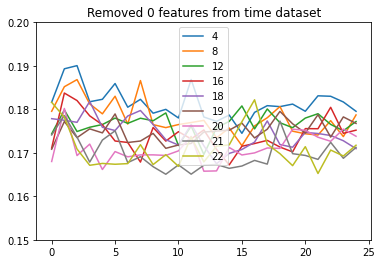

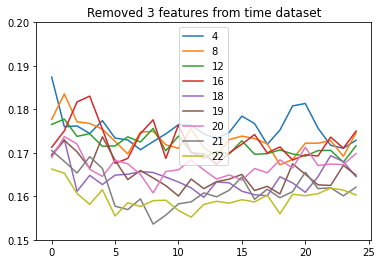

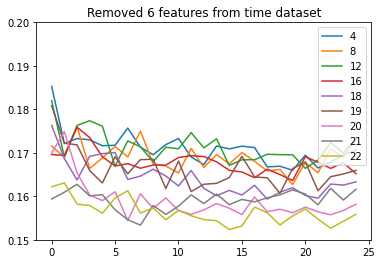

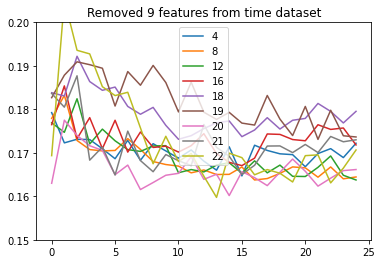

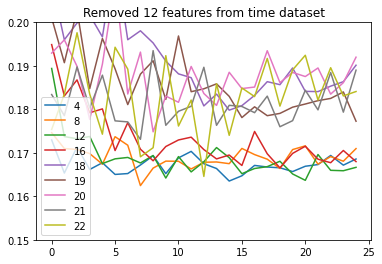

In [359]:
# modelList[-1][-1].append([])
# print(modelList)
val_loss3 = np.array([ [ [ z.history['val_loss'] for z in y ] for y in x ] for x in historyList2 ] )
val_loss_avg3 = np.mean(val_loss3, axis = 2)

for i_time, _ in enumerate(numRemove_time_list):
    plt.figure(i_time)
    for i_static, _ in enumerate(numRemove_static_list):
        plt.plot(val_loss_avg3[i_static, i_time, :])
    plt.ylim(0.15, 0.20)
    plt.legend(numRemove_static_list)
    plt.title('Removed %d features from time dataset' % (numRemove_time_list[i_time]))
    plt.show

In [362]:
my_data = {'num removed features_time': numRemove_time_list,
           'num removed features_static': numRemove_static_list,
           'validation loss': val_loss_avg}
output = open('valLoss_after removing features_4.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

In [363]:
sortedFeatures_static = [columns_aftPCA[i] for i in idx_static]

inputSize = 7
normalizeTarget = False

quantile = 0.5
num_epoch = 25

NUM_CELLS = 128
NUM_DAYS_OUT = 14

num_repeat = 2
modelList = []
historyList2 = []

numRemove_time_list = [1, 2, 4, 5, 7, 8]
numRemove_static_list = [22]

for numRemove_static in numRemove_static_list:
    modelList.append([])
    historyList2.append([])
    
    columns_static_selected = sortedFeatures_static[numRemove_static:]
    print(columns_static_selected)

    # choose features from static data
    dataList_static_PCA, fips_noData_static_PCA, fips_final_static_PCA = concatDF_static(
        df_berk_withPCA, columns_static_selected, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])
    
    # normzliation
    data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)

    # for static dataset
    trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

    for numRemove_time in numRemove_time_list:
        print('numRemove_static: %d' %(numRemove_static))
        print('numRemove_time: %d' %(numRemove_time))
        
        modelList[-1].append([])
        historyList2[-1].append([])
        
        columns_time_selected = sortedFeatures_time[numRemove_time:]

        # choose features from time-series data
        columns_mortality = ['cases', 'deaths']
        columns_mobility = ['m50', 'm50_index']
        columns_season = ['seasonality']
        columns_testResult = ['positive', 'negative', 'pending', 'hospitalizedCurrently',
               'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
               'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 
               'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease',
               'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
               'totalTestResultsIncrease'] 
        columns_mortality_tmp = [ x for x in columns_mortality if x in columns_time_selected]
        columns_mobility_tmp = [ x for x in columns_mobility if x in columns_time_selected]
        columns_season_tmp = [ x for x in columns_season if x in columns_time_selected]
        columns_testResult_tmp = [ x for x in columns_testResult if x in columns_time_selected]
        columns_time_selected_reorder = columns_mortality_tmp+columns_mobility_tmp+columns_season_tmp+columns_testResult_tmp
        dataList_time, fips_noData_time, fips_final_time = concatDF_timeseries(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, df_testResult_eachCounty,
                                                                 columns_mortality_tmp, columns_mobility_tmp, columns_season_tmp, columns_testResult_tmp,
                                                                 fipsList, df_fips2state, df_berk2, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 0)
        print(columns_time_selected_reorder)

        # normalization
        data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

        # for timeseries dataset
        trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time_selected_reorder)

        # unnormalize the targets
        if not normalizeTarget:
            trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time_selected_reorder, 'deaths')

            
        # train the model
        for rep in range(num_repeat):
            model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
            model.call([trainingData_time, trainingData_static])
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
            history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
                      validation_data=([testingData_time, testingData_static], testingAns_time),
                      epochs=num_epoch, shuffle=True, batch_size=64)
            modelList[-1][-1].append(model)
            historyList2[-1][-1].append(history)
            

['pc0_highCorr']
fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not found
fips  02261 not found
fips  02290 not found
fips  08014 not found
fips  46102 not found
numRemove_static: 22
numRemove_time: 1
['cases', 'deaths', 'positive', 'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'recovered', 'hospitalized', 'deathIncrease', 'negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease']
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 14s 100us/sample - loss: 0.1275 - val_loss: 0.1673
Epoch 2/25
136770/136770 [==============================] - 13s 94us/sample - loss: 0.1136 - val_loss: 0.1678
Epoch 3/25
136770/136770 [==============================] - 13s 9

136770/136770 [==============================] - 13s 95us/sample - loss: 0.0962 - val_loss: 0.1567
Epoch 16/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0957 - val_loss: 0.1559
Epoch 17/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0951 - val_loss: 0.1606
Epoch 18/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0945 - val_loss: 0.1636
Epoch 19/25
136770/136770 [==============================] - 14s 101us/sample - loss: 0.0940 - val_loss: 0.1604
Epoch 20/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0939 - val_loss: 0.1666
Epoch 21/25
136770/136770 [==============================] - 13s 95us/sample - loss: 0.0932 - val_loss: 0.1629
Epoch 22/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.0926 - val_loss: 0.1603
Epoch 23/25
136770/136770 [==============================] - 14s 99us/sample - loss: 0.0923 - val_loss: 0.1685
Epoch 24/25


136770/136770 [==============================] - 13s 98us/sample - loss: 0.1007 - val_loss: 0.1548
Epoch 11/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1000 - val_loss: 0.1569
Epoch 12/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0994 - val_loss: 0.1551
Epoch 13/25
136770/136770 [==============================] - 14s 100us/sample - loss: 0.0985 - val_loss: 0.1541
Epoch 14/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0986 - val_loss: 0.1576
Epoch 15/25
136770/136770 [==============================] - 13s 99us/sample - loss: 0.0974 - val_loss: 0.1650
Epoch 16/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0964 - val_loss: 0.1666
Epoch 17/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.0959 - val_loss: 0.1565
Epoch 18/25
136770/136770 [==============================] - 14s 100us/sample - loss: 0.0955 - val_loss: 0.1705
Epoch 19/25

136770/136770 [==============================] - 13s 96us/sample - loss: 0.1108 - val_loss: 0.1913
Epoch 5/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1090 - val_loss: 0.1804
Epoch 6/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1076 - val_loss: 0.1783
Epoch 7/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1061 - val_loss: 0.1744
Epoch 8/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1046 - val_loss: 0.1698
Epoch 9/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1035 - val_loss: 0.1632
Epoch 10/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1026 - val_loss: 0.1707
Epoch 11/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1019 - val_loss: 0.1683
Epoch 12/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.1010 - val_loss: 0.1692
Epoch 13/25
136770

136770/136770 [==============================] - 14s 101us/sample - loss: 0.1277 - val_loss: 0.1881
Epoch 2/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1162 - val_loss: 0.1853
Epoch 3/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.1131 - val_loss: 0.1789
Epoch 4/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.1110 - val_loss: 0.1880
Epoch 5/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.1094 - val_loss: 0.1617
Epoch 6/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1074 - val_loss: 0.1716
Epoch 7/25
136770/136770 [==============================] - 13s 96us/sample - loss: 0.1065 - val_loss: 0.1657
Epoch 8/25
136770/136770 [==============================] - 13s 98us/sample - loss: 0.1053 - val_loss: 0.1679
Epoch 9/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.1041 - val_loss: 0.1680
Epoch 10/25
136770/1

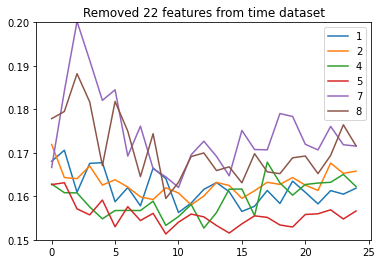

In [368]:
# modelList[-1][-1].append([])
# print(modelList)
val_loss3 = np.array([ [ [ z.history['val_loss'] for z in y ] for y in x ] for x in historyList2 ] )
val_loss_avg3 = np.mean(val_loss3, axis = 2)

for i_static, _ in enumerate(numRemove_static_list):
    plt.figure(i_static)
    for i_time, _ in enumerate(numRemove_time_list):
        plt.plot(val_loss_avg3[i_static, i_time, :])
    plt.ylim(0.15, 0.20)
    plt.legend(numRemove_time_list)
    plt.title('Removed %d features from time dataset' % (numRemove_static_list[i_static]))
    plt.show

In [369]:
my_data = {'num removed features_time': numRemove_time_list,
           'num removed features_static': numRemove_static_list,
           'validation loss': val_loss_avg3}
output = open('valLoss_after removing features_5.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

In [370]:
# See if additional weekday feature helps
sortedFeatures_static = [columns_aftPCA[i] for i in idx_static]

inputSize = 7
normalizeTarget = False

quantile = 0.5
num_epoch = 25

NUM_CELLS = 128
NUM_DAYS_OUT = 14

num_repeat = 2
modelList = []
historyList2 = []

numRemove_time_list = [5]
numRemove_static_list = [22]

for numRemove_static in numRemove_static_list:
    modelList.append([])
    historyList2.append([])
    
    columns_static_selected = sortedFeatures_static[numRemove_static:]
    print(columns_static_selected)

    # choose features from static data
    dataList_static_PCA, fips_noData_static_PCA, fips_final_static_PCA = concatDF_static(
        df_berk_withPCA, columns_static_selected, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])
    
    # normzliation
    data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)

    # for static dataset
    trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

    for numRemove_time in numRemove_time_list:
        print('numRemove_static: %d' %(numRemove_static))
        print('numRemove_time: %d' %(numRemove_time))
        
        modelList[-1].append([])
        historyList2[-1].append([])
        
        columns_time_selected = sortedFeatures_time[numRemove_time:]

        # choose features from time-series data
        columns_mortality = ['cases', 'deaths', 'weekday']
        columns_mobility = ['m50', 'm50_index']
        columns_season = ['seasonality']
        columns_testResult = ['positive', 'negative', 'pending', 'hospitalizedCurrently',
               'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
               'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 
               'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease',
               'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
               'totalTestResultsIncrease'] 
        columns_mortality_tmp = [ x for x in columns_mortality if x in columns_time_selected]
        columns_mortality_tmp = columns_mortality_tmp + ['weekday']
        columns_mobility_tmp = [ x for x in columns_mobility if x in columns_time_selected]
        columns_season_tmp = [ x for x in columns_season if x in columns_time_selected]
        columns_testResult_tmp = [ x for x in columns_testResult if x in columns_time_selected]
        columns_time_selected_reorder = columns_mortality_tmp+columns_mobility_tmp+columns_season_tmp+columns_testResult_tmp
        dataList_time, fips_noData_time, fips_final_time = concatDF_timeseries(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, df_testResult_eachCounty,
                                                                 columns_mortality_tmp, columns_mobility_tmp, columns_season_tmp, columns_testResult_tmp,
                                                                 fipsList, df_fips2state, df_berk2, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 0)
        print(columns_time_selected_reorder)

        # normalization
        data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

        # for timeseries dataset
        trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time_selected_reorder)

        # unnormalize the targets
        if not normalizeTarget:
            trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time_selected_reorder, 'deaths')

            
        # train the model
        for rep in range(num_repeat):
            model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
            model.call([trainingData_time, trainingData_static])
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
            history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
                      validation_data=([testingData_time, testingData_static], testingAns_time),
                      epochs=num_epoch, shuffle=True, batch_size=64)
            modelList[-1][-1].append(model)
            historyList2[-1][-1].append(history)
            

['pc0_highCorr']
fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not found
fips  02261 not found
fips  02290 not found
fips  08014 not found
fips  46102 not found
numRemove_static: 22
numRemove_time: 5
['cases', 'deaths', 'weekday', 'positive', 'hospitalizedCumulative', 'recovered', 'hospitalized', 'deathIncrease', 'positiveIncrease', 'totalTestResultsIncrease']
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 14s 104us/sample - loss: 0.1275 - val_loss: 0.1590
Epoch 2/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.1144 - val_loss: 0.1707
Epoch 3/25
136770/136770 [==============================] - 13s 97us/sample - loss: 0.1108 - val_loss: 0.1511
Epoch 4/25
136770/136770 [

<function matplotlib.pyplot.show(*args, **kw)>

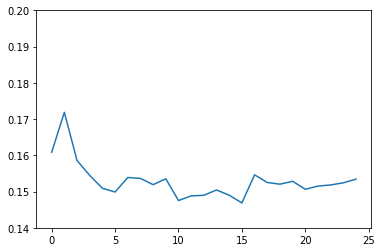

In [373]:
# modelList[-1][-1].append([])
# print(modelList)
val_loss4 = np.array([ [ [ z.history['val_loss'] for z in y ] for y in x ] for x in historyList2 ] )
val_loss_avg4 = np.mean(val_loss4, axis = 2)


plt.plot(val_loss_avg4[0, 0, :])
plt.ylim(0.14, 0.20)
#plt.title('Removed %d features from time dataset' % (numRemove_static_list[i_static]))
plt.show

In [374]:
my_data = {'num removed features_time': numRemove_time_list,
           'num removed features_static': numRemove_static_list,
           'validation loss': val_loss_avg4}
output = open('valLoss_after removing features_6_withWeekdays.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

In [375]:
# See if additional weekday feature helps
sortedFeatures_static = [columns_aftPCA[i] for i in idx_static]

inputSize = 7
normalizeTarget = False

quantile = 0.5
num_epoch = 25

NUM_CELLS = 256
NUM_DAYS_OUT = 14

num_repeat = 2
modelList = []
historyList2 = []

numRemove_time_list = [5]
numRemove_static_list = [22]

for numRemove_static in numRemove_static_list:
    modelList.append([])
    historyList2.append([])
    
    columns_static_selected = sortedFeatures_static[numRemove_static:]
    print(columns_static_selected)

    # choose features from static data
    dataList_static_PCA, fips_noData_static_PCA, fips_final_static_PCA = concatDF_static(
        df_berk_withPCA, columns_static_selected, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])
    
    # normzliation
    data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)

    # for static dataset
    trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

    for numRemove_time in numRemove_time_list:
        print('numRemove_static: %d' %(numRemove_static))
        print('numRemove_time: %d' %(numRemove_time))
        
        modelList[-1].append([])
        historyList2[-1].append([])
        
        columns_time_selected = sortedFeatures_time[numRemove_time:]

        # choose features from time-series data
        columns_mortality = ['cases', 'deaths', 'weekday']
        columns_mobility = ['m50', 'm50_index']
        columns_season = ['seasonality']
        columns_testResult = ['positive', 'negative', 'pending', 'hospitalizedCurrently',
               'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
               'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 
               'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease',
               'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
               'totalTestResultsIncrease'] 
        columns_mortality_tmp = [ x for x in columns_mortality if x in columns_time_selected]
        columns_mortality_tmp = columns_mortality_tmp + ['weekday']
        columns_mobility_tmp = [ x for x in columns_mobility if x in columns_time_selected]
        columns_season_tmp = [ x for x in columns_season if x in columns_time_selected]
        columns_testResult_tmp = [ x for x in columns_testResult if x in columns_time_selected]
        columns_time_selected_reorder = columns_mortality_tmp+columns_mobility_tmp+columns_season_tmp+columns_testResult_tmp
        dataList_time, fips_noData_time, fips_final_time = concatDF_timeseries(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, df_testResult_eachCounty,
                                                                 columns_mortality_tmp, columns_mobility_tmp, columns_season_tmp, columns_testResult_tmp,
                                                                 fipsList, df_fips2state, df_berk2, fips_final_static, date_st, date_ed, df_nyt_eachCounty_accum, 0)
        print(columns_time_selected_reorder)

        # normalization
        data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

        # for timeseries dataset
        trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time_selected_reorder)

        # unnormalize the targets
        if not normalizeTarget:
            trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time_selected_reorder, 'deaths')

            
        # train the model
        for rep in range(num_repeat):
            model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
            model.call([trainingData_time, trainingData_static])
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
            history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
                      validation_data=([testingData_time, testingData_static], testingAns_time),
                      epochs=num_epoch, shuffle=True, batch_size=64)
            modelList[-1][-1].append(model)
            historyList2[-1][-1].append(history)
            

['pc0_highCorr']
fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not found
fips  02261 not found
fips  02290 not found
fips  08014 not found
fips  46102 not found
numRemove_static: 22
numRemove_time: 5
['cases', 'deaths', 'weekday', 'positive', 'hospitalizedCumulative', 'recovered', 'hospitalized', 'deathIncrease', 'positiveIncrease', 'totalTestResultsIncrease']
Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 29s 210us/sample - loss: 0.1241 - val_loss: 0.1579
Epoch 2/25
136770/136770 [==============================] - 27s 200us/sample - loss: 0.1121 - val_loss: 0.1583
Epoch 3/25
136770/136770 [==============================] - 28s 201us/sample - loss: 0.1083 - val_loss: 0.1477
Epoch 4/25
136770/136770

KeyboardInterrupt: 